## 1. –ò–º–ø–æ—Ä—Ç –±–∏–±–ª–∏–æ—Ç–µ–∫

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statistics import mode, multimode
from itertools import combinations
from scipy.stats import ttest_ind, pearsonr, f_oneway
import statsmodels.api as sm
import scipy.stats as sst
import warnings
from datetime import datetime
from datetime import date
import time
import re

import requests
from bs4 import BeautifulSoup

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler,\
                                  MinMaxScaler, KBinsDiscretizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, auc, roc_auc_score, roc_curve, accuracy_score,\
precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score

%matplotlib inline
warnings.filterwarnings('ignore')

## 2. –û–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Ñ—É–Ω–∫—Ü–∏–π

In [2]:
# –ü—Ä–æ–≤–µ—Ä–∫–∞ –∑–∞–ø—Ä–æ—Å–æ–≤ —Å –≤–æ–∑–≤—Ä–∞—Ç–æ–º –∫–æ–¥–∞ –æ—Ç–≤–µ—Ç–∞
def get_html(url, params=None):
    response = requests.get(url, params=params)
    response.encoding = 'utf-8'
    return response

In [3]:
# –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è –¥–∞–Ω–Ω—ã—Ö
def histogram(df):
    sns.set()
    f, axes = plt.subplots(figsize=(15, 5))
    sns.distplot(df, kde = False, rug=False)
    plt.xticks(rotation=90)
    
def boxplot(x_data, y_data, data):
    sns.set(style="ticks", palette="pastel")
    f, axes = plt.subplots()
    sns.boxplot(x=x_data, y=y_data, palette=['m', 'g'], data = data)
    sns.despine(offset=10, trim=True)
    
def countplot(x_data, df):
    f, ax = plt.subplots(figsize=(16, 9))
    ax = sns.countplot(x=x_data, data=df)
    plt.xticks(rotation=90)
    
def bar(column):
    """
    Plots pie chart and bar chart
    for given categorical feature
    """
    fig, axes = plt.subplots(figsize=(12, 6))
    
    sns.barplot(x=train[column].astype(str).value_counts().index[:5],
                y=train[column].value_counts(normalize=True).values[:5],
                palette='magma')
    plt.title(f'Top train categories for "{column}"',
              size=15)
    plt.ylabel('Proportion')
    
    plt.xticks(rotation=90)
    plt.subplots_adjust(wspace=0.2);

def dist_box(data, column):
    """
    Plots distribution
    and boxplot for given
    numeric feature
    """
    fig, axes = plt.subplots(4, 2, figsize=(15, 10))
    sns.kdeplot(data[column], ax=axes[0][0],
                color='r', shade=True)
    axes[0][0].set_title(f'Distribution for "{column}"',
                      size=15)
    sns.boxplot(data[column], ax=axes[0][1],
                color='r', meanline=True)
    axes[0][1].set_title(f'Box plot for "{column}"',
                      size=15)
    
    sns.kdeplot(np.log(data[column] + 1), ax=axes[1][0],
                color='violet', shade=True)
    axes[1][0].set_title(f'Log-distribution for "{column}"',
                      size=15)
    
    sns.boxplot(np.log(data[column] + 1), ax=axes[1][1],
                color='violet', meanline=True)
    axes[1][1].set_title(f'Box plot for logarithmic "{column}"',
                      size=15)
    
    robust_scaler = RobustScaler(quantile_range = (0.25, 0.75)).\
    fit_transform(data[column].values.reshape(-1, 1))
#     scaler = StandardScaler().fit_transform(data[column].values.reshape(-1, 1))
    
    sns.kdeplot(np.log(robust_scaler.reshape(len(robust_scaler), ) + 1), 
                ax=axes[2][0], color='green', shade=True)
    
    axes[2][0].set_title(f'Robust log-distribution for"{column}"', size=15)
    
    sns.boxplot(np.log(robust_scaler + 1), ax=axes[2][1], color='green', meanline=True)
    axes[2][1].set_title(f'Box plot for robust logarithmic "{column}"',
                      size=15)
    
    minmax_scaler = MinMaxScaler().fit_transform(data[column].values.reshape(-1, 1))
    
    sns.kdeplot(minmax_scaler.reshape(len(minmax_scaler), ), 
                ax=axes[3][0], color='orange', shade=True)
    
    axes[3][0].set_title(f'Minmax normalized for"{column}"', size=15)
    
    sns.boxplot(minmax_scaler, ax=axes[3][1], color='orange', meanline=True)
    axes[3][1].set_title(f'Box plot for minmax normalized "{column}"',
                      size=15)
    
    plt.subplots_adjust(wspace=0.1, hspace=0.3);
    
def outliers(column):
    """
    This function detects
    outliers relying on
    IQR and displays IQR bounds
    and the number of outliers
    """
    Q1 = np.quantile(column, 0.25)
    Q3 = np.quantile(column, 0.75) 
    IQR = Q3 - Q1
    left_bound = Q1 - 1.5*IQR
    right_bound = Q3 + 1.5*IQR
    bounds = pd.Series({'left bound': left_bound,
                        'right bound': right_bound})
    number_of_outliers = column[(column > right_bound) | (column < left_bound)]
    return bounds, number_of_outliers.shape[0]

def show_plots(x_data, y_data, data):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (16, 9)) # 3 –≥—Ä–∞—Ñ–∏–∫–∞ –Ω–∞ –æ–¥–∏–Ω –ø—Ä–∏–∑–Ω–∞–∫ –≤ —Ä—è–¥
    fig.suptitle('QQ-plot, histogram and boxplot for {0}'.format(value))
    
    fig = sm.qqplot(y_data.dropna(), fit = True, line ='45', ax=ax1) # —Å—Ä–∞–≤–Ω–µ–Ω–∏–µ —Å –Ω–æ—Ä–º–∞–ª—å–Ω—ã–º —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ–º
    sns.distplot(y_data.dropna(), kde=False, bins=50, ax=ax2) # –≥–∏—Å—Ç–æ–≥—Ä–∞–º–º–∞
    sns.boxplot(x=x_data.dropna(), y=y_data.dropna(), data=data, palette='rainbow', ax=ax3) # –≤—ã–±—Ä–æ—Å—ã
    
    plt.show

In [4]:
# MAPE
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true) * 100)

## 3. –ó–∞–≥—Ä—É–∑–∫–∞ –¥–∞–Ω–Ω—ã—Ö

–ü–æ —É—Å–ª–æ–≤–∏—è–º –∑–∞–¥–∞–Ω–∏—è –∏–º–µ–µ–º —Ç–µ—Å—Ç–æ–≤—ã–π –¥–∞—Ç–∞—Å–µ—Ç –∏ –≤–∞—Ä–∏–∞–Ω—Ç –∑–∞–≥—Ä—É–∑–∫–∏ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤ –Ω–∞ kaggle. –¢—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω—ã–π –¥–∞—Ç–∞—Å–µ—Ç –ø—Ä–µ–¥—Å—Ç–æ–∏—Ç —Å–æ–±—Ä–∞—Ç—å —Å–∞–º–∏–º.

In [5]:
data = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [6]:
data['sell_id'].to_excel('C:/Users/shers/Desktop/SF/–ü—Ä–æ–µ–∫—Ç—ã/–í—ã–±–∏—Ä–∞–µ–º –∞–≤—Ç–æ –≤—ã–≥–æ–¥–Ω–æ/sell_id.xlsx')

In [7]:
# –∑–∞—Ñ–∏–∫—Å–∏—Ä—É–µ–º –∫–æ–Ω—Å—Ç–∞–Ω—Ç—ã
!pip freeze > requirements.txt
RANDOM_SEED = 42
CURRENT_DATE = datetime.now()

In [8]:
print('–†–∞–∑–º–µ—Ä–Ω–æ—Å—Ç—å —Ç–µ—Å—Ç–æ–≤–æ–≥–æ –¥–∞—Ç–∞—Å–µ—Ç–∞: ', data.shape)

–†–∞–∑–º–µ—Ä–Ω–æ—Å—Ç—å —Ç–µ—Å—Ç–æ–≤–æ–≥–æ –¥–∞—Ç–∞—Å–µ—Ç–∞:  (34686, 32)


In [9]:
data.head()

bodyType  brand                                            car_url  \
0  –ª–∏—Ñ—Ç–±–µ–∫  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   
1  –ª–∏—Ñ—Ç–±–µ–∫  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   
2  –ª–∏—Ñ—Ç–±–µ–∫  SKODA  https://auto.ru/cars/used/sale/skoda/superb/11...   
3  –ª–∏—Ñ—Ç–±–µ–∫  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   
4  –ª–∏—Ñ—Ç–±–µ–∫  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   

        color                                 complectation_dict  \
0       —Å–∏–Ω–∏–π                                                NaN   
1      —á—ë—Ä–Ω—ã–π                                                NaN   
2       —Å–µ—Ä—ã–π  {"id":"20026336","name":"Ambition","available_...   
3  –∫–æ—Ä–∏—á–Ω–µ–≤—ã–π  {"id":"20803582","name":"Ambition","available_...   
4       –±–µ–ª—ã–π                                                NaN   

                                         description engineDisplacement  \
0  –í—Å–µ –∞–≤—Ç–æ–º–æ–±–∏–ª–∏, –ø—Ä–µ–¥—Å—Ç–∞–≤–ª–µ–Ω–Ω—ã–µ –≤ –ø—Ä–æ–¥–∞–∂–µ, –ø—Ä–æ—Ö...            1.2 LTR   
1  –õ–û–¢: 01217195\n–ê–≤—Ç–æ–ø—Ä–∞–≥–∞ –°–µ–≤–µ—Ä\n–î–∞–Ω–Ω—ã–π –∞–≤—Ç–æ–º–æ–±...            1.6 LTR   
2  –í—Å–µ –∞–≤—Ç–æ–º–æ–±–∏–ª–∏, –ø—Ä–µ–¥—Å—Ç–∞–≤–ª–µ–Ω–Ω—ã–µ –≤ –ø—Ä–æ–¥–∞–∂–µ, –ø—Ä–æ—Ö...            1.8 LTR   
3  –ö–û–ú–ü–õ–ï–ö–¢ –ó–ò–ú–ù–ï–ô (–õ–ï–¢–ù–ï–ô) –†–ï–ó–ò–ù–´ –ü–û –°–ï–ó–û–ù–£ –í –ü–û...            1.6 LTR   
4  –õ–û–¢: 01220889\n–ê–≤—Ç–æ–ø—Ä–∞–≥–∞ –°–µ–≤–µ—Ä\n\n–í—ã –º–æ–∂–µ—Ç–µ –ø–æ...            1.8 LTR   

  enginePower                                     equipment_dict fuelType  \
0     105 N12  {"engine-proof":true,"tinted-glass":true,"airb...   –±–µ–Ω–∑–∏–Ω   
1     110 N12  {"cruise-control":true,"asr":true,"esp":true,"...   –±–µ–Ω–∑–∏–Ω   
2     152 N12  {"cruise-control":true,"tinted-glass":true,"es...   –±–µ–Ω–∑–∏–Ω   
3     110 N12  {"cruise-control":true,"roller-blind-for-rear-...   –±–µ–Ω–∑–∏–Ω   
4     152 N12  {"cruise-control":true,"asr":true,"esp":true,"...   –±–µ–Ω–∑–∏–Ω   

   ...     vehicleConfiguration  vehicleTransmission    vendor    –í–ª–∞–¥–µ–ª—å—Ü—ã  \
0  ...       LIFTBACK ROBOT 1.2     —Ä–æ–±–æ—Ç–∏–∑–∏—Ä–æ–≤–∞–Ω–Ω–∞—è  EUROPEAN  3 –∏–ª–∏ –±–æ–ª–µ–µ   
1  ...  LIFTBACK MECHANICAL 1.6         –º–µ—Ö–∞–Ω–∏—á–µ—Å–∫–∞—è  EUROPEAN   1¬†–≤–ª–∞–¥–µ–ª–µ—Ü   
2  ...       LIFTBACK ROBOT 1.8     —Ä–æ–±–æ—Ç–∏–∑–∏—Ä–æ–≤–∞–Ω–Ω–∞—è  EUROPEAN   1¬†–≤–ª–∞–¥–µ–ª–µ—Ü   
3  ...   LIFTBACK AUTOMATIC 1.6       –∞–≤—Ç–æ–º–∞—Ç–∏—á–µ—Å–∫–∞—è  EUROPEAN   1¬†–≤–ª–∞–¥–µ–ª–µ—Ü   
4  ...   LIFTBACK AUTOMATIC 1.8       –∞–≤—Ç–æ–º–∞—Ç–∏—á–µ—Å–∫–∞—è  EUROPEAN   1¬†–≤–ª–∞–¥–µ–ª–µ—Ü   

  –í–ª–∞–¥–µ–Ω–∏–µ       –ü–¢–°    –ü—Ä–∏–≤–æ–¥   –†—É–ª—å           –°–æ—Å—Ç–æ—è–Ω–∏–µ     –¢–∞–º–æ–∂–Ω—è  
0      NaN  –û—Ä–∏–≥–∏–Ω–∞–ª  –ø–µ—Ä–µ–¥–Ω–∏–π  –õ–µ–≤—ã–π  –ù–µ —Ç—Ä–µ–±—É–µ—Ç —Ä–µ–º–æ–Ω—Ç–∞  –†–∞—Å—Ç–∞–º–æ–∂–µ–Ω  
1      NaN  –û—Ä–∏–≥–∏–Ω–∞–ª  –ø–µ—Ä–µ–¥–Ω–∏–π  –õ–µ–≤—ã–π  –ù–µ —Ç—Ä–µ–±—É–µ—Ç —Ä–µ–º–æ–Ω—Ç–∞  –†–∞—Å—Ç–∞–º–æ–∂–µ–Ω  
2      NaN  –û—Ä–∏–≥–∏–Ω–∞–ª  –ø–µ—Ä–µ–¥–Ω–∏–π  –õ–µ–≤—ã–π  –ù–µ —Ç—Ä–µ–±—É–µ—Ç —Ä–µ–º–æ–Ω—Ç–∞  –†–∞—Å—Ç–∞–º–æ–∂–µ–Ω  
3      NaN  –û—Ä–∏–≥–∏–Ω–∞–ª  –ø–µ—Ä–µ–¥–Ω–∏–π  –õ–µ–≤—ã–π  –ù–µ —Ç—Ä–µ–±—É–µ—Ç —Ä–µ–º–æ–Ω—Ç–∞  –†–∞—Å—Ç–∞–º–æ–∂–µ–Ω  
4      NaN  –û—Ä–∏–≥–∏–Ω–∞–ª  –ø–µ—Ä–µ–¥–Ω–∏–π  –õ–µ–≤—ã–π  –ù–µ —Ç—Ä–µ–±—É–µ—Ç —Ä–µ–º–æ–Ω—Ç–∞  –†–∞—Å—Ç–∞–º–æ–∂–µ–Ω  

[5 rows x 32 columns]

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

–û–ø–∏—Å–∞–Ω–∏–µ –ø–µ—Ä–µ–º–µ–Ω–Ω—ã—Ö:

1. bodyType - —Ç–∏–ø –∫—É–∑–æ–≤–∞. 24 –≤–∞—Ä–∏–∞–Ω—Ç–∞: —Å–µ–¥–∞–Ω

2. brand - –∞–≤—Ç–æ–º–æ–±–∏–ª—å–Ω—ã–π –±—Ä–µ–Ω–¥

3. car_url - —Å—Å—ã–ª–∫–∞ –Ω–∞ –æ–±—ä—è–≤–ª–µ–Ω–∏–µ

4. color - —Ü–≤–µ—Ç –∞–≤—Ç–æ–º–æ–±–∏–ª—è

5. complectation_dict - —Å–ª–æ–≤–∞—Ä—å —Å —Å–æ–¥–µ—Ä–∂–∏–º—ã–º –∫–æ–º–ø–ª–µ–∫—Ç–∞—Ü–∏–∏

6. description - –æ–ø–∏—Å–∞–Ω–∏–µ –ø—Ä–æ–¥–∞–≤—Ü–∞

7. engineDisplacement - –æ–±—ä–µ–º –¥–≤–∏–≥–∞—Ç–µ–ª—è (–Ω—É–∂–Ω–æ –±—É–¥–µ—Ç –ø–æ–¥—á–∏—Å—Ç–∏—Ç—å –æ—Ç LTR)

8. enginePower - –º–æ—â–Ω–æ—Å—Ç—å –¥–≤–∏–≥–∞—Ç–µ–ª—è (–Ω—É–∂–Ω–æ –±—É–¥–µ—Ç –ø–æ–¥—á–∏—Å—Ç–∏—Ç—å –æ—Ç N12)

9. equipment_dict - —Å–ª–æ–≤–∞—Ä—å —Å –æ—Å–Ω–∞—â–µ–Ω–∏–µ–º, –∫–ª—é—á - —Ç–∏–ø –æ—Å–Ω–∞—â–µ–Ω–∏—è, –∞ –∑–Ω–∞—á–µ–Ω–∏–µ —Ç–æ–ª—å–∫–æ true

10. fuelType - —Ç–∏–ø –∏—Å–ø–æ–ª—å–∑—É–µ–º–æ–≥–æ —Ç–æ–ø–ª–∏–≤–∞

11. image - —Å—Å—ã–ª–∫–∞ –Ω–∞ —Ñ–æ—Ç–æ

12. mileage - –ø—Ä–æ–±–µ–≥

13. modelDate - –≥–æ–¥ –ø–æ—è–≤–ª–µ–Ω–∏—è –º–æ–¥–µ–ª–∏

14. model_info - —Å–ª–æ–≤–∞—Ä—å —Å –Ω–∞–∑–≤–∞–Ω–∏–µ–º –º–æ–¥–µ–ª–∏ –Ω–∞ –∞–Ω–≥–∏–π—Å–∫–æ–º –∏ —Ä—É—Å—Å–∫–æ–º, –∞ —Ç–∞–∫–∂–µ —Å–µ–º–∞–Ω—Ç–∏—á–µ—Å–∫–∞—è –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏—è (–º–æ–∂–Ω–æ –ø–æ–ø—Ä–æ–±–æ–≤–∞—Ç—å –≤—ã–¥–µ–ª–∏—Ç—å –Ω–∞–∑–≤–∞–Ω–∏–µ –º–æ–¥–µ–ª–∏ –Ω–∞ —Ä—É—Å—Å–∫–æ–º, –µ—Å–ª–∏ –ø–æ—Ç—Ä–µ–±—É–µ—Ç—Å—è)

15. model_name - –Ω–∞–∑–≤–∞–Ω–∏–µ –º–æ–¥–µ–ª–∏ –Ω–∞ –∞–Ω–≥–ª.

16. name - —Å–æ–∫—Ä–∞—â–µ–Ω–Ω–æ–µ –Ω–∞–∏–º–µ–Ω–æ–≤–∞–Ω–∏–µ –∫–æ–º–ø–ª–µ–∫—Ç–∞—Ü–∏–∏ –∞–≤—Ç–æ–º–æ–±–∏–ª—è (—Ç–∏–ø –¥–≤–∏–≥–∞—Ç–µ–ª—è, –µ–≥–æ –º–æ—â–Ω–æ—Å—Ç—å, —Ç–∏–ø –∫–æ—Ä–æ–±–∫–∏ –ø–µ—Ä–µ–¥–∞—á, –ø–æ–ª–Ω—ã–π –ø—Ä–∏–≤–æ–¥)

17. numberOfDoors - –∫–æ–ª-–≤–æ –¥–≤–µ—Ä–µ–π

18. parsing_unixtime - –≤—Ä–µ–º—è –≤ –º–æ–º–µ–Ω—Ç –ø–∞—Ä—Å–∏–Ω–≥–∞ –≤ —Ñ–æ—Ä–º–∞—Ç–µ unix 

19. priceCurrency - —É –≤—Å–µ—Ö –∑–Ω–∞—á–µ–Ω–∏–π RUB.

20. productionDate - –≥–æ–¥ –≤—ã–ø—É—Å–∫–∞

21. sell_id - –∏–¥–µ–Ω—Ç–∏—Ñ–∏–∫–∞—Ç–æ—Ä –æ–±—ä—è–≤–ª–µ–Ω–∏—è

22. super_gen - —Å–ª–æ–≤–∞—Ä—å —Å –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏–µ–π –æ –∫–æ–º–ø–ª–µ–∫—Ç–∞—Ü–∏–∏: id, –º–∞—Å—Å–∞, —Ç–∏–ø –¥–≤–∏–≥–∞—Ç–µ–ª—è, –º–∞—Ä–∫–∞ —à–∏–Ω, —Ç–∏–ø —Ç—Ä–∞–Ω—Å–º–∏—Å—Å–∏–∏, –º–æ—â–Ω–æ—Å—Ç—å –≤ –ª—Å, –º–æ—â–Ω–æ—Å—Ç—å –≤ –∫–≤—Ç, –∫—Ä–∞—Ç–∫–æ–µ –æ–ø–∏—Å–∞–Ω–∏–µ –∫–æ–º–ø–ª–µ–∫—Ç–∞—Ü–∏–∏, –≤—Ä–µ–º—è —Ä–∞–∑–≥–æ–Ω–∞ –¥–æ 100, –≤–µ–ª–∏—á–∏–Ω–∞ –¥–æ—Ä–æ–∂–Ω–æ–≥–æ –ø—Ä–æ—Å–≤–µ—Ç–∞, —ç–∫–æ–ª–æ–≥–∏—á–µ—Å–∫–∞—è —Ö–∞—Ä–∞–∫—Ç–µ—Ä–∏—Å—Ç–∏–∫–∞.

23. vehicleConfiguration - —Ç—Ä–∏ –∑–Ω–∞—á–µ–Ω–∏—è –Ω–∞ –∞–Ω–≥–ª.: —Ç–∏–ø –∫—É–∑–æ–≤–∞, —Ç–∏–ø —Ç—Ä–∞–Ω—Å–º–∏—Å—Å–∏–∏, –æ–±—ä–µ–º –¥–≤–∏–≥–∞—Ç–µ–ª—è

24. vehicleTransmission - —Ç–∏–ø —Ç—Ä–∞–Ω—Å–º–∏—Å—Å–∏–∏ –Ω–∞ —Ä—É—Å—Å–∫–æ–º

25. vendor - —Å—Ç—Ä–∞–Ω–∞ –ø—Ä–æ–∏—Å—Ö–æ–∂–¥–µ–Ω–∏—è –º–∞—Ä–∫–∏: –µ–≤—Ä–æ–ø–∞, —è–ø–æ–Ω–∏—è

26. –í–ª–∞–¥–µ–ª—å—Ü—ã - —á–∏—Å–ª–æ –≤–ª–∞–¥–µ–ª—å—Ü–µ–≤: 1, 2, 3 –∏ –±–æ–ª–µ–µ. –ù—É–∂–Ω–æ –ø–æ–¥—á–∏—Å—Ç–∏—Ç—å –æ—Ç –æ–∫–æ–Ω—á–∞–Ω–∏—è –ø–æ —Ä–æ–¥—É -–ª–µ—Ü -–ª–∏—Ü–∞

27. –í–ª–∞–¥–µ–Ω–∏–µ - –ø—Ä–æ–¥–æ–ª–∂–∏—Ç–µ–ª—å–Ω–æ—Å—Ç—å –≤–ª–∞–¥–µ–Ω–∏—è —á–∏—Å–ª–æ –ª–µ—Ç –∏ –º–µ—Å—è—Ü–µ–≤

28. –ü–¢–° - –æ—Ä–∏–≥–∏–Ω–∞–ª –∏–ª–∏ –¥—É–±–ª–∏–∫–∞—Ç

29. –ü—Ä–∏–≤–æ–¥ - –ø–µ—Ä–µ–∑–Ω–∏–π, –∑–∞–¥–Ω–∏–π, –ø–æ–ª–Ω—ã–π

30. –†—É–ª—å - –ø—Ä–∞–≤—ã–π –∏–ª–∏ –ª–µ–≤—ã–π

31. –°–æ—Å—Ç–æ—è–Ω–∏–µ - —É –≤—Å–µ—Ö –∑–Ω–∞—á–µ–Ω–∏–µ - –ù–µ —Ç—Ä–µ–±—É–µ—Ç —Ä–µ–º–æ–Ω—Ç–∞

32. –¢–∞–º–æ–∂–Ω—è - —É –≤—Å–µ—Ö –∑–Ω–∞—á–µ–Ω–∏–µ - —Ä–∞—Å—Ç–∞–º–æ–∂–µ–Ω


## 4. –ü—Ä–µ–¥–≤–∞—Ä–∏—Ç–µ–ª—å–Ω—ã–π –∞–Ω–∞–ª–∏–∑ –¥–∞–Ω–Ω—ã—Ö —Ç–µ—Å—Ç–æ–≤–æ–π –≤—ã–±–æ—Ä–∫–∏

In [11]:
features = data.columns
for col in features:
   print('–£–Ω–∏–∫–∞–ª—å–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è –≤ –ø–æ–ª–µ {0} : {1}'.format(col, data[col].unique()))

–£–Ω–∏–∫–∞–ª—å–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è –≤ –ø–æ–ª–µ bodyType : ['–ª–∏—Ñ—Ç–±–µ–∫' '–≤–Ω–µ–¥–æ—Ä–æ–∂–Ω–∏–∫ 5 –¥–≤.' '—Ö—ç—Ç—á–±–µ–∫ 5 –¥–≤.' '—Å–µ–¥–∞–Ω' '–∫–æ–º–ø–∞–∫—Ç–≤—ç–Ω'
 '—É–Ω–∏–≤–µ—Ä—Å–∞–ª 5 –¥–≤.' '–ø–∏–∫–∞–ø –æ–¥–∏–Ω–∞—Ä–Ω–∞—è –∫–∞–±–∏–Ω–∞' '—Ö—ç—Ç—á–±–µ–∫ 3 –¥–≤.' '–∫—É–ø–µ'
 '–∫–∞–±—Ä–∏–æ–ª–µ—Ç' '–º–∏–Ω–∏–≤—ç–Ω' '–ø–∏–∫–∞–ø –¥–≤–æ–π–Ω–∞—è –∫–∞–±–∏–Ω–∞' '–≤–Ω–µ–¥–æ—Ä–æ–∂–Ω–∏–∫ 3 –¥–≤.'
 '—Ä–æ–¥—Å—Ç–µ—Ä' '–º–∏–∫—Ä–æ–≤—ç–Ω' '—Å–µ–¥–∞–Ω 2 –¥–≤.' '–∫—É–ø–µ-—Ö–∞—Ä–¥—Ç–æ–ø' '—Ñ–∞—Å—Ç–±–µ–∫' '—Ç–∞—Ä–≥–∞'
 '–≤–Ω–µ–¥–æ—Ä–æ–∂–Ω–∏–∫ –æ—Ç–∫—Ä—ã—Ç—ã–π' '–ª–∏–º—É–∑–∏–Ω' '–ø–∏–∫–∞–ø –ø–æ–ª—É—Ç–æ—Ä–Ω–∞—è –∫–∞–±–∏–Ω–∞'
 '—Å–µ–¥–∞–Ω-—Ö–∞—Ä–¥—Ç–æ–ø' '—Ñ—É—Ä–≥–æ–Ω']
–£–Ω–∏–∫–∞–ª—å–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è –≤ –ø–æ–ª–µ brand : ['SKODA' 'AUDI' 'HONDA' 'VOLVO' 'BMW' 'NISSAN' 'INFINITI' 'MERCEDES'
 'TOYOTA' 'LEXUS' 'VOLKSWAGEN' 'MITSUBISHI']
–£–Ω–∏–∫–∞–ª—å–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è –≤ –ø–æ–ª–µ car_url : ['https://auto.ru/cars/used/sale/skoda/octavia/1100575026-c780dc09/'
 'https://auto.ru/cars/used/sale/sko

–£–Ω–∏–∫–∞–ª—å–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è –≤ –ø–æ–ª–µ description : ['–í—Å–µ –∞–≤—Ç–æ–º–æ–±–∏–ª–∏, –ø—Ä–µ–¥—Å—Ç–∞–≤–ª–µ–Ω–Ω—ã–µ –≤ –ø—Ä–æ–¥–∞–∂–µ, –ø—Ä–æ—Ö–æ–¥—è—Ç —Ç—â–∞—Ç–µ–ª—å–Ω—É—é –ø—Ä–æ–≤–µ—Ä–∫—É –ø–æ –±–æ–ª–µ–µ 40 –ø–∞—Ä–∞–º–µ—Ç—Ä–∞–º. –ü—Ä–µ–¥–æ—Å—Ç–∞–≤–ª—è–µ–º –≥–∞—Ä–∞–Ω—Ç–∏—é —é—Ä–∏–¥–∏—á–µ—Å–∫–æ–π —á–∏—Å—Ç–æ—Ç—ã, –∞ —Ç–∞–∫ –∂–µ –≥–æ–¥ —Ç–µ—Ö–Ω–∏—á–µ—Å–∫–æ–π –≥–∞—Ä–∞–Ω—Ç–∏–∏ –Ω–∞ –¥–≤–∏–≥–∞—Ç–µ–ª—å –∏ –ö–ü–ü. –ë–µ—Å–ø–ª–∞—Ç–Ω—ã–π —Ç–µ—Å—Ç-–¥—Ä–∞–π–≤. –í–æ–∑–º–æ–∂–Ω–æ –æ—Ñ–æ—Ä–º–ª–µ–Ω–∏–µ –∞–≤—Ç–æ–º–æ–±–∏–ª—è –≤ –∫—Ä–µ–¥–∏—Ç!\n\n–ü—Ä–µ–∏–º—É—â–µ—Å—Ç–≤–∞ –∞–≤—Ç–æ–∫—Ä–µ–¥–∏—Ç–æ–≤–∞–Ω–∏—è:\n‚Äî –ü–µ—Ä–≤–æ–Ω–∞—á–∞–ª—å–Ω—ã–π –≤–∑–Ω–æ—Å –æ—Ç 0%;\n‚Äî –ë–æ–ª–µ–µ 30 –∫—Ä–µ–¥–∏—Ç–Ω—ã—Ö –ø—Ä–æ–≥—Ä–∞–º–º;\n‚Äî –ü—Ä–æ—Ü–µ–Ω—Ç–Ω–∞—è —Å—Ç–∞–≤–∫–∞ –æ—Ç 6% –≥–æ–¥–æ–≤—ã—Ö;\n‚Äî –°—Ä–æ–∫ –∫—Ä–µ–¥–∏—Ç–∞ –æ—Ç 6 –º–µ—Å—è—Ü–µ–≤ –¥–æ 7 –ª–µ—Ç;\n‚Äî –û—Ñ–æ—Ä–º–ª–µ–Ω–∏–µ –∫—Ä–µ–¥–∏—Ç–∞ –ø–æ –¥–≤—É–º –¥–æ–∫—É–º–µ–Ω—Ç–∞–º;\n‚Äî –î–æ—Å—Ä–æ—á–Ω–æ–µ –ø–æ–≥–∞—à–µ–Ω–∏–µ –±–µ–∑ —à—Ç—Ä–∞—Ñ–æ–≤ –∏ –∫–æ–º–∏—Å—Å–∏–π;

–£–Ω–∏–∫–∞–ª—å–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è –≤ –ø–æ–ª–µ super_gen : ['{"id":"10373605","displacement":1197,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"ROBOT","power":105,"power_kvt":77,"human_name":"1.2 AMT (105 –ª.—Å.)","acceleration":10.5,"clearance_min":155,"fuel_rate":5}'
 '{"id":"20913311","displacement":1598,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"MECHANICAL","power":110,"power_kvt":81,"human_name":"1.6 MT (110 –ª.—Å.)","acceleration":10.8,"clearance_min":156,"fuel_rate":6.4}'
 '{"id":"20026323","nameplate":"DSG","displacement":1798,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"ROBOT","power":152,"power_kvt":112,"human_name":"DSG 1.8 AMT (152 –ª.—Å.)","acceleration":8.7,"clearance_min":139,"fuel_rate":7.1,"clearance_max":158}'
 ...
 '{"id":"21221044","name":"320","nameplate":"320i","displacement":1991,"engine_type":"GASOLINE","gear_type":"REAR_DRIVE","transmission":"MECHANICAL","power":150,"power_kvt":11

In [12]:
data.describe(include = 'object')

bodyType  brand                                            car_url  \
count     34686  34686                                              34686   
unique       24     12                                              34686   
top       —Å–µ–¥–∞–Ω    BMW  https://auto.ru/cars/used/sale/bmw/3er/1092383...   
freq      13147   4473                                                  1   

         color                                 complectation_dict  \
count    34686                                               6418   
unique      16                                               2364   
top     —á—ë—Ä–Ω—ã–π  {"id":"4562904","name":"Elegance","available_o...   
freq     11010                                                 51   

                                              description engineDisplacement  \
count                                               34686              34686   
unique                                              31732                 55   
top     –í—ã–≥–æ–¥–∞ –¥–æ 82 000 —Ä—É–±. –ø—Ä–∏ –æ–±–º–µ–Ω–µ –Ω–∞ –í–∞—à –∞–≤—Ç–æ–º–æ...            2.0 LTR   
freq                                                  264               7391   

       enginePower    equipment_dict fuelType  ...  \
count        34686             24690    34686  ...   
unique         315             23705        5  ...   
top        249 N12  {"leather":true}   –±–µ–Ω–∑–∏–Ω  ...   
freq          1708               108    28601  ...   

                 vehicleConfiguration vehicleTransmission    vendor  \
count                           34686               34686     34686   
unique                            634                   4         2   
top     ALLROAD_5_DOORS AUTOMATIC 3.0      –∞–≤—Ç–æ–º–∞—Ç–∏—á–µ—Å–∫–∞—è  EUROPEAN   
freq                             2389               19596     20682   

          –í–ª–∞–¥–µ–ª—å—Ü—ã            –í–ª–∞–¥–µ–Ω–∏–µ       –ü–¢–°    –ü—Ä–∏–≤–æ–¥   –†—É–ª—å  \
count         34686               11995     34685     34686  34686   
unique            3                 275         2         3      2   
top     3 –∏–ª–∏ –±–æ–ª–µ–µ  1 –≥–æ–¥ –∏ 10 –º–µ—Å—è—Ü–µ–≤  –û—Ä–∏–≥–∏–Ω–∞–ª  –ø–µ—Ä–µ–¥–Ω–∏–π  –õ–µ–≤—ã–π   
freq          15957                 209     30098     15565  33287   

                 –°–æ—Å—Ç–æ—è–Ω–∏–µ     –¢–∞–º–æ–∂–Ω—è  
count                34686       34686  
unique                   1           1  
top     –ù–µ —Ç—Ä–µ–±—É–µ—Ç —Ä–µ–º–æ–Ω—Ç–∞  –†–∞—Å—Ç–∞–º–æ–∂–µ–Ω  
freq                 34686       34686  

[4 rows x 26 columns]

#### car_url
–ü–æ–∫–∞ –Ω–µ –≤–∏–∂—É —Å–º—ã—Å–ª–∞ –≤–∫–ª—é—á–∞—Ç—å —ç—Ç–∏ –¥–∞–Ω–Ω—ã–µ –≤ –∏—Ç–æ–≥–æ–≤—ã–π –¥–∞—Ç–∞—Å–µ—Ç.

#### complectation_dict
–ú–æ–∂–Ω–æ –ø–æ–¥—Ç—è–Ω—É—Ç—å –¥–∞–Ω–Ω—ã–µ –ø–æ –æ–ø—Ü–∏—è–º –∞–≤—Ç–æ–º–æ–±–∏–ª—è, –Ω–æ —ç—Ç–æ –∑–∞–π–º–µ—Ç –≤—Ä–µ–º—è –∏ –±—É–¥–µ—Ç –º–Ω–æ–≥–æ –ø—Ä–æ–ø—É—Å–∫–æ–≤, —á—Ç–æ –Ω–µ–≥–∞—Ç–∏–≤–Ω–æ —Å–∫–∞–∂–µ—Ç—Å—è –Ω–∞ –º–æ–¥–µ–ª–∏, –ø–æ –º–æ–µ–º—É –º–Ω–µ–Ω–∏—é. –ü–æ–∫–∞ –¥—É–º–∞—é —É–±—Ä–∞—Ç—å –∏–∑ –∏—Ç–æ–≥–æ–≤–æ–≥–æ –î–°.

#### engineDisplacement
–ù—É–∂–Ω–æ –ø—Ä–∏–≤–µ—Å—Ç–∏ –≤ —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤–∏–µ —Å –¥–∞–Ω–Ω—ã–º–∏ —Å —Å–∞–π—Ç–∞, –ø–æ—ç—Ç–æ–º—É –æ—Å—Ç–∞–≤–ª—è–µ–º —Ç–æ–ª—å–∫–æ –¥–≤–µ —Ü–∏—Ñ—Ä—ã —Å —Ä–∞–∑–µ–ª–∏—Ç–µ–ª—å–Ω–æ–π —Ç–æ—á–∫–æ–π, –æ—Å—Ç–∞–ª—å–Ω–æ–µ –ø–æ–¥—á–∏—â–∞–µ–º.

In [13]:
col = 'engineDisplacement'
data[col] = data[col].str.extract(r'(\d.\d)').astype(float)

In [14]:
# –ù–∞–ª–∏—á–∏–µ –ø—Ä–æ–ø—É—Å–∫–æ–≤ –≤ —Ç–æ–º, —á—Ç–æ —ç—Ç–æ —ç–ª–µ–∫—Ç—Ä–æ–º–æ–±–∏–ª–∏ –±–µ–∑ –î–í–°
col = 'engineDisplacement'
data.query('engineDisplacement=="NaN"')

bodyType       brand  \
5241   –≤–Ω–µ–¥–æ—Ä–æ–∂–Ω–∏–∫ 5 –¥–≤.        AUDI   
7992       —Ö—ç—Ç—á–±–µ–∫ 5 –¥–≤.         BMW   
8252       —Ö—ç—Ç—á–±–µ–∫ 5 –¥–≤.         BMW   
8350       —Ö—ç—Ç—á–±–µ–∫ 5 –¥–≤.         BMW   
8684       —Ö—ç—Ç—á–±–µ–∫ 5 –¥–≤.         BMW   
8722       —Ö—ç—Ç—á–±–µ–∫ 5 –¥–≤.         BMW   
8917       —Ö—ç—Ç—á–±–µ–∫ 5 –¥–≤.         BMW   
10817      —Ö—ç—Ç—á–±–µ–∫ 5 –¥–≤.         BMW   
10936      —Ö—ç—Ç—á–±–µ–∫ 5 –¥–≤.         BMW   
11043      —Ö—ç—Ç—á–±–µ–∫ 5 –¥–≤.         BMW   
11302      —Ö—ç—Ç—á–±–µ–∫ 5 –¥–≤.      NISSAN   
11682      —Ö—ç—Ç—á–±–µ–∫ 5 –¥–≤.      NISSAN   
11714      —Ö—ç—Ç—á–±–µ–∫ 5 –¥–≤.      NISSAN   
11719      —Ö—ç—Ç—á–±–µ–∫ 5 –¥–≤.      NISSAN   
11754      —Ö—ç—Ç—á–±–µ–∫ 5 –¥–≤.      NISSAN   
11878      —Ö—ç—Ç—á–±–µ–∫ 5 –¥–≤.      NISSAN   
11974      —Ö—ç—Ç—á–±–µ–∫ 5 –¥–≤.      NISSAN   
12072      —Ö—ç—Ç—á–±–µ–∫ 5 –¥–≤.      NISSAN   
12085      —Ö—ç—Ç—á–±–µ–∫ 5 –¥–≤.      NISSAN   
12100      —Ö—ç—Ç—á–±–µ–∫ 5 –¥–≤.      NISSAN   
12250      —Ö—ç—Ç—á–±–µ–∫ 5 –¥–≤.      NISSAN   
12287      —Ö—ç—Ç—á–±–µ–∫ 5 –¥–≤.      NISSAN   
12334      —Ö—ç—Ç—á–±–µ–∫ 5 –¥–≤.      NISSAN   
12466      —Ö—ç—Ç—á–±–µ–∫ 5 –¥–≤.      NISSAN   
12481      —Ö—ç—Ç—á–±–µ–∫ 5 –¥–≤.      NISSAN   
12558      —Ö—ç—Ç—á–±–µ–∫ 5 –¥–≤.      NISSAN   
12582      —Ö—ç—Ç—á–±–µ–∫ 5 –¥–≤.      NISSAN   
12678      —Ö—ç—Ç—á–±–µ–∫ 5 –¥–≤.      NISSAN   
12749      —Ö—ç—Ç—á–±–µ–∫ 5 –¥–≤.      NISSAN   
12854      —Ö—ç—Ç—á–±–µ–∫ 5 –¥–≤.      NISSAN   
12916      —Ö—ç—Ç—á–±–µ–∫ 5 –¥–≤.      NISSAN   
12948      —Ö—ç—Ç—á–±–µ–∫ 5 –¥–≤.      NISSAN   
12950      —Ö—ç—Ç—á–±–µ–∫ 5 –¥–≤.      NISSAN   
13052      —Ö—ç—Ç—á–±–µ–∫ 5 –¥–≤.      NISSAN   
13104      —Ö—ç—Ç—á–±–µ–∫ 5 –¥–≤.      NISSAN   
13105      —Ö—ç—Ç—á–±–µ–∫ 5 –¥–≤.      NISSAN   
13478      —Ö—ç—Ç—á–±–µ–∫ 5 –¥–≤.      NISSAN   
13633      —Ö—ç—Ç—á–±–µ–∫ 5 –¥–≤.      NISSAN   
13660      —Ö—ç—Ç—á–±–µ–∫ 5 –¥–≤.      NISSAN   
13720      —Ö—ç—Ç—á–±–µ–∫ 5 –¥–≤.      NISSAN   
13812      —Ö—ç—Ç—á–±–µ–∫ 5 –¥–≤.      NISSAN   
13915      —Ö—ç—Ç—á–±–µ–∫ 5 –¥–≤.      NISSAN   
13952      —Ö—ç—Ç—á–±–µ–∫ 5 –¥–≤.      NISSAN   
13989      —Ö—ç—Ç—á–±–µ–∫ 5 –¥–≤.      NISSAN   
14147      —Ö—ç—Ç—á–±–µ–∫ 5 –¥–≤.      NISSAN   
14419      —Ö—ç—Ç—á–±–µ–∫ 5 –¥–≤.      NISSAN   
23869      —Ö—ç—Ç—á–±–µ–∫ 5 –¥–≤.  VOLKSWAGEN   
23948      —Ö—ç—Ç—á–±–µ–∫ 5 –¥–≤.  VOLKSWAGEN   
27064      —Ö—ç—Ç—á–±–µ–∫ 5 –¥–≤.  MITSUBISHI   
28241      —Ö—ç—Ç—á–±–µ–∫ 5 –¥–≤.  MITSUBISHI   
32668      —Ö—ç—Ç—á–±–µ–∫ 5 –¥–≤.      NISSAN   
32700      —Ö—ç—Ç—á–±–µ–∫ 5 –¥–≤.      NISSAN   
32798      —Ö—ç—Ç—á–±–µ–∫ 5 –¥–≤.      NISSAN   
34159      —Ö—ç—Ç—á–±–µ–∫ 5 –¥–≤.    MERCEDES   
34504      —Ö—ç—Ç—á–±–µ–∫ 5 –¥–≤.      NISSAN   

                                                 car_url        color  \
5241   https://auto.ru/cars/used/sale/audi/e_tron/110...        –±–µ–ª—ã–π   
7992   https://auto.ru/cars/used/sale/bmw/i3/11010431...        —Å–∏–Ω–∏–π   
8252   https://auto.ru/cars/used/sale/bmw/i3/11012780...        —Å–µ—Ä—ã–π   
8350   https://auto.ru/cars/used/sale/bmw/i3/11002716...        –±–µ–ª—ã–π   
8684   https://auto.ru/cars/used/sale/bmw/i3/11011745...       —á—ë—Ä–Ω—ã–π   
8722   https://auto.ru/cars/used/sale/bmw/i3/11000973...      –≥–æ–ª—É–±–æ–π   
8917   https://auto.ru/cars/used/sale/bmw/i3/11008715...      –±–µ–∂–µ–≤—ã–π   
10817  https://auto.ru/cars/used/sale/bmw/i3/11012664...        —Å–µ—Ä—ã–π   
10936  https://auto.ru/cars/used/sale/bmw/i3/10996733...       —á—ë—Ä–Ω—ã–π   
11043  https://auto.ru/cars/used/sale/bmw/i3/10993761...        —Å–µ—Ä—ã–π   
11302  https://auto.ru/cars/used/sale/nissan/leaf/110...      –≥–æ–ª—É–±–æ–π   
11682  https://auto.ru/cars/used/sale/nissan/leaf/110...        –±–µ–ª—ã–π   
11714  https://auto.ru/cars/used/sale/nissan/leaf/109...        –±–µ–ª—ã–π   
11719  https://auto.ru/cars/used/sale/nissan/leaf/109...        –±–µ–ª—ã–π   
11754  https://auto.ru/cars/used/sale/nissan/leaf/110...        –±–µ–ª—ã–π   
11878  https://auto.ru/ca

#### enginePower
–£–±–∏—Ä–∞–µ–º –ª–∏—à–Ω–∏–µ —Å–∏–º–≤–æ–ª—ã.

In [15]:
col = 'enginePower'
data[col] = data[col].str.extract(r'(\d{2,3})').astype(int)

#### equipment_dict
–ê–Ω–∞–ª–æ–≥–∏—á–Ω–æ 'complectation_dict', –Ω–æ –∑–¥–µ—Å—å –¥–∞–Ω–Ω—ã–µ —á–∏—â–µ. –ú–æ–∂–Ω–æ –ø–æ–ø—Ä–æ–±–æ–≤–∞—Ç—å —Å–¥–µ–ª–∞—Ç—å dummie-–ø–µ—Ä–µ–º–µ–Ω–Ω—ã–µ. –ù–æ: –º–Ω–æ–≥–æ –æ–±—ä—è–≤–ª–µ–Ω–∏–π, –≥–¥–µ –æ—Ç—Å—É—Ç—Å—Ç–≤—É–µ—Ç —á–∞—Å—Ç–∏—á–Ω–æ –∏–ª–∏ –ø–æ–ª–Ω–æ—Å—Ç—å—é. –ù–µ –±—É–¥—É –≤–∫–ª—é—á–∞—Ç—å –≤ –∏—Ç–æ–≥–æ–≤—ã–π –¥–∞—Ç–∞—Å–µ—Ç.

#### image
–û–±—ä–µ–∫—Ç –ø—Ä–µ–¥—Å—Ç–∞–≤–ª—è–µ—Ç —Å–æ–±–æ–π —Å—Å—ã–ª–∫—É –Ω–∞ —Ñ–æ—Ç–æ –∞–≤—Ç–æ–º–æ–±–∏–ª—è. –ù–µ –±—É–¥–µ–º –≤–∫–ª—é—á–∞—Ç—å –≤ –∏—Ç–æ–≥–æ–≤—ã–π –¥–∞—Ç–∞—Å–µ—Ç. –ö–æ–º–ø—å—é—Ç–µ—Ä–Ω–æ–µ –∑—Ä–µ–Ω–∏–µ –Ω–∞ –¥–∞–Ω–Ω–æ–º —ç—Ç–∞–ø–µ –Ω–µ –ø–ª–∞–Ω–∏—Ä—É–µ—Ç—Å—è –∫ –ø—Ä–∏–º–µ–Ω–µ–Ω–∏—é. –ù–µ –±—É–¥–µ–º –≤–∫–ª—é—á–∞—Ç—å –≤ –∏—Ç–æ–≥–æ–≤—ã–π –¥–∞—Ç–∞—Å–µ—Ç.

#### modelDate
–î–∞–Ω–Ω–æ–π –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏–∏ –Ω–∞ auto.ru –Ω–µ—Ç. –ù—É–∂–Ω–æ –±—É–¥–µ—Ç –ø–æ–¥—Ç—è–≥–∏–≤–∞—Ç—å —Å–æ —Å—Ç–æ—Ä–æ–Ω–Ω–∏—Ö —Ä–µ—Å—É—Ä—Å–æ–≤. –î–æ—Å—Ç–∞—Ç–æ—á–Ω–æ –≤–∞–∂–Ω–∞—è –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏—è, —Ç.–∫. —Ä–µ—Å—Ç–∞–π–ª–∏–Ω–≥ –º–æ–∂–µ—Ç –±—ã—Ç—å –≤ —Å–µ—Ä–µ–¥–∏–Ω–µ –≥–æ–¥–∞ –∏ –∞–≤—Ç–æ–º–æ–±–∏–ª–∏ –æ–¥–Ω–æ–≥–æ –≥–æ–¥–∞ –º–æ–≥—É—Ç –±—ã—Ç—å –≤ —Ä–∞–∑–Ω—ã—Ö —Ü–µ–Ω–≤—ã—Ö –∫–∞—Ç–µ–≥–æ—Ä–∏—è—Ö. –ü–æ–∫–∞ —ç—Ç—É –º—ã—Å–ª—å –Ω–µ —Ä–µ–∞–ª–∏–∑–æ–≤–∞–ª.

#### model_info
–ó–¥–µ—Å—å –º–æ–∂–Ω–æ –≤–∑—è—Ç—å –Ω–∞–∑–≤–∞–Ω–∏–µ –º–æ–¥–µ–ª–∏ –Ω–∞ —Ä—É—Å—Å–∫–æ–º —è–∑—ã–∫–µ. –ò—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å —ç—Ç—É –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏—é –≤ –ø–æ–∏—Å–∫–µ. –ù–µ—Ç –º—ã—Å–ª–µ–π –Ω–∞ —ç—Ç–æ—Ç —Å—á–µ—Ç. –ù–µ –±—É–¥–µ–º –≤–∫–ª—é—á–∞—Ç—å –≤ –∏—Ç–æ–≥–æ–≤—ã–π –¥–∞—Ç–∞—Å–µ—Ç.

#### name
–ò–Ω—Ñ–æ—Ä–º–∞—Ü–∏—è –¥—É–±–ª–∏—Ä—É–µ—Ç—Å—è —Å –¥—Ä—É–≥–∏–º–∏ —Å—Ç–æ–ª–±—Ü–∞–º–∏, –Ω–∞–ø—Ä–∏–º–µ—Ä –æ–±—ä–µ–º –¥–≤–∏–≥–∞—Ç–µ–ª—è, —Ç–∏–ø —Ç–æ–ø–ª–∏–≤–∞, —Ç–∏–ø —Ç—Ä–∞–Ω—Å–º–∏—Å—Å–∏–∏, –º–æ—â–Ω–æ—Å—Ç—å –¥–≤–∏–≥–∞—Ç–µ–ª—è. –í–æ–∑—å–º–µ–º –æ—Ç—Å—é–¥–∞ –æ–±—ä–µ–º –¥–≤–∏–≥–∞—Ç–µ–ª—è.

In [16]:
col = 'name'
data[col] = data[col].str.extract(r'(\d\.\d)')

In [17]:
data[col].unique()

array(['1.2', '1.6', '1.8', '2.0', '1.4', '1.3', '1.0', '3.6', '1.5',
       '1.9', '2.8', '1.1', '2.5', '4.2', '3.0', '4.0', '5.9', '2.7',
       '3.1', '2.4', '5.2', '3.2', '4.1', '6.3', '2.3', '6.0', '2.2',
       '3.7', '2.9', '5.0', '3.3', '2.1', '2.6', nan, '3.5', '1.7', '0.7',
       '4.4', '4.8', '5.4', '6.6', '4.9', '3.8', '3.4', '3.9', '4.6',
       '5.6', '4.5', '5.5', '6.2', '4.7', '4.3', '5.8', '5.3', '5.7'],
      dtype=object)

#### numberOfDoors
–ò–Ω—Ñ–æ—Ä–º–∞—Ü–∏—è —á–∞—Å—Ç–∏—á–Ω–æ –¥—É–±–ª–∏—Ä—É–µ—Ç—Å—è —Å –¥—Ä—É–≥–∏–º –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–º. –ù–∞ —Å–∞–π—Ç–µ auto.ru —Ç–∞–∫–æ–π –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏–∏ –Ω–µ—Ç. –ù–µ –±—É–¥–µ–º –≤–∫–ª—é—á–∞—Ç—å —ç—Ç–æ—Ç —Å—Ç–æ–ª–±–µ—Ü –≤ –∏—Ç–æ–≥–æ–≤—ã–π –¥–∞—Ç–∞—Å–µ—Ç.

#### priceCurrency
–í—Å–µ –∑–Ω–∞—á–µ–Ω–∏—è –æ–¥–∏–Ω–∞–∫–æ–≤—ã. –ú–æ–∂–Ω–æ –Ω–µ –≤–∫–ª—é—á–∞—Ç—å –≤ –∏—Ç–æ–≥–æ–≤—ã–π –¥–∞—Ç–∞—Å–µ—Ç.

#### sell_id
–ù—É–∂–Ω–∞ —Ç–æ–ª—å–∫–æ –¥–ª—è –∑–∞–≥—Ä—É–∑–∫–∏ –Ω–∞ kaggle. –ü—Ä–∏ —Å–æ—Å—Ç–∞–≤–ª–µ–Ω–∏–∏ –º–æ–¥–µ–ª–∏ –Ω—É–∂–Ω–æ —É–±—Ä–∞—Ç—å –µ–µ.

In [18]:
data_id = data.sell_id

#### super_gen
–ß–∞—Å—Ç–∏—á–Ω–æ –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏—è –¥—É–±–ª–∏—Ä—É–µ—Ç—Å—è —Å –¥—Ä—É–≥–∏–º–∏ –ø–∞—Ä–∞–º–µ—Ç—Ä–∞–º–∏ –¥–∞—Ç–∞—Å–µ—Ç–∞, —á–∞—Å—Ç–∏—á–Ω–æ –Ω–µ –ø—Ä–µ–¥—Å—Ç–∞–≤–ª–µ–Ω–Ω–∞ –Ω–∞ auto.ru. –ù–µ –±—É–¥–µ–º –≤–∫–ª—é—á–∞—Ç—å –≤ –∏—Ç–æ–≥–æ–≤—ã–π –¥–∞—Ç–∞—Å–µ—Ç.

#### vehicleConfiguration
–ß–∞—Å—Ç–∏—á–Ω–æ –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏—è –¥—É–±–ª–∏—Ä—É–µ—Ç—Å—è —Å –¥—Ä—É–≥–∏–º–∏ –ø–∞—Ä–∞–º–µ—Ç—Ä–∞–º–∏ –¥–∞—Ç–∞—Å–µ—Ç–∞. –ù–µ –±—É–¥–µ–º –≤–∫–ª—é—á–∞—Ç—å –≤ –∏—Ç–æ–≥–æ–≤—ã–π –¥–∞—Ç–∞—Å–µ—Ç.

#### –í–ª–∞–¥–µ–ª—å—Ü—ã
–£–¥–∞–ª–∏–º –ª–∏—à–Ω–∏–µ —Å–∏–º–≤–æ–ª—ã.

In [19]:
col = '–í–ª–∞–¥–µ–ª—å—Ü—ã'
data[col] = data[col].str.extract(r'(\d)').astype(float)

#### –í–ª–∞–¥–µ–Ω–∏–µ
–¢–∏–ø –¥–∞–Ω–Ω—ã—Ö —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É–µ—Ç –∑–∞–ø—Ä–æ—Å–∞–º —Å —Å–∞–π—Ç–∞ auto.ru. –ü–µ—Ä–µ—Ñ–æ—Ä–º–∞—Ç–∏—Ä—É–µ–º –≤ —á–∏—Å–ª–æ–≤–æ–π —Ñ–æ—Ä–º–∞—Ç: –∫–æ–ª-–≤–æ –ª–µ—Ç.

In [20]:
col = '–í–ª–∞–¥–µ–Ω–∏–µ'
data[col] = data[col].apply(lambda x: re.findall(r'(\d{1,2})', str(x)))
data[col] = data[col].apply(lambda x: np.nan if len(x)==0 else \
                                        (float(x[0])/12 if len(x)==1 else float(x[0])+float(x[1])/12))

#### –°–æ—Å—Ç–æ—è–Ω–∏–µ
–í —Ç–µ—Å—Ç–æ–≤–æ–º –î–° —Ç–æ–ª—å–∫–æ –æ–¥–Ω–æ –∑–Ω–∞—á–µ–Ω–∏–µ. –û—Å—Ç–∞–≤–∏—Ç—å –≤ —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω–æ–º —Ç–æ–∂–µ —Ç–æ–ª—å–∫–æ –µ–≥–æ.

#### –¢–∞–º–æ–∂–Ω—è
–í —Ç–µ—Å—Ç–æ–≤–æ–º –î–° —Ç–æ–ª—å–∫–æ –æ–¥–Ω–æ –∑–Ω–∞—á–µ–Ω–∏–µ. –û—Å—Ç–∞–≤–∏—Ç—å –≤ —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω–æ–º —Ç–æ–∂–µ —Ç–æ–ª—å–∫–æ –µ–≥–æ.

In [21]:
#–ü—Ä–∏–≤–µ–¥–µ–Ω–∏–µ –≤—Ä–µ–º–µ–Ω–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –∫ –µ–¥–∏–Ω–æ–º—É —Ñ–æ—Ä–º–∞—Ç—É
data['parsing_unixtime'] = pd.to_datetime(data['parsing_unixtime'], unit='s')
data['parsing_unixtime'] = pd.DatetimeIndex(data['parsing_unixtime']).year
data['productionDate'] = pd.to_datetime(data['productionDate'], format='%Y')
data['productionDate'] = pd.DatetimeIndex(data['productionDate']).year

In [22]:
data = data.drop([
    'car_url', 'complectation_dict', 'equipment_dict', 'image', 'modelDate', 'model_info', 'name',
    'numberOfDoors', 'priceCurrency', 'sell_id', 'super_gen', 'vehicleConfiguration', '–°–æ—Å—Ç–æ—è–Ω–∏–µ', 
    '–¢–∞–º–æ–∂–Ω—è'
], axis=1)

In [23]:
# –§–ª–∞–≥ –¥–ª—è –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏ –∫–∞–∫ —Ç–µ—Å—Ç–æ–≤–æ–π –≤—ã–±–æ—Ä–∫–∏
data['flag'] = '0'

# 5. –°–æ–∑–¥–∞–Ω–∏–µ —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω–æ–≥–æ –¥–∞—Ç–∞—Å–µ—Ç–∞

–° —Å–∞–π—Ç–∞ auto.ru –Ω–µ–æ–±—Ö–æ–¥–∏–º—ã —Å–ª–µ–¥—É—é—â–∏–µ –¥–∞–Ω–Ω—ã–µ:

1. bodyType - —Ç–∏–ø –∫—É–∑–æ–≤–∞. 24 –≤–∞—Ä–∏–∞–Ω—Ç–∞: —Å–µ–¥–∞–Ω

2. brand - –∞–≤—Ç–æ–º–æ–±–∏–ª—å–Ω—ã–π –±—Ä–µ–Ω–¥

4. color - —Ü–≤–µ—Ç –∞–≤—Ç–æ–º–æ–±–∏–ª—è

6. description - –æ–ø–∏—Å–∞–Ω–∏–µ –ø—Ä–æ–¥–∞–≤—Ü–∞

7. engineDisplacement - –æ–±—ä–µ–º –¥–≤–∏–≥–∞—Ç–µ–ª—è (–Ω—É–∂–Ω–æ –±—É–¥–µ—Ç –ø–æ–¥—á–∏—Å—Ç–∏—Ç—å –æ—Ç LTR)

8. enginePower - –º–æ—â–Ω–æ—Å—Ç—å –¥–≤–∏–≥–∞—Ç–µ–ª—è (–Ω—É–∂–Ω–æ –±—É–¥–µ—Ç –ø–æ–¥—á–∏—Å—Ç–∏—Ç—å –æ—Ç N12)

9. equipment_dict - —Å–ª–æ–≤–∞—Ä—å —Å –æ—Å–Ω–∞—â–µ–Ω–∏–µ–º, –∫–ª—é—á - —Ç–∏–ø –æ—Å–Ω–∞—â–µ–Ω–∏—è, –∞ –∑–Ω–∞—á–µ–Ω–∏–µ —Ç–æ–ª—å–∫–æ true

10. fuelType - —Ç–∏–ø –∏—Å–ø–æ–ª—å–∑—É–µ–º–æ–≥–æ —Ç–æ–ø–ª–∏–≤–∞

12. mileage - –ø—Ä–æ–±–µ–≥

15. model_name - –Ω–∞–∑–≤–∞–Ω–∏–µ –º–æ–¥–µ–ª–∏ –Ω–∞ –∞–Ω–≥–ª.

20. productionDate - –≥–æ–¥ –≤—ã–ø—É—Å–∫–∞

24. vehicleTransmission - —Ç–∏–ø —Ç—Ä–∞–Ω—Å–º–∏—Å—Å–∏–∏ –Ω–∞ —Ä—É—Å—Å–∫–æ–º

26. –í–ª–∞–¥–µ–ª—å—Ü—ã - —á–∏—Å–ª–æ –≤–ª–∞–¥–µ–ª—å—Ü–µ–≤: 1, 2, 3 –∏ –±–æ–ª–µ–µ. –ù—É–∂–Ω–æ –ø–æ–¥—á–∏—Å—Ç–∏—Ç—å –æ—Ç –æ–∫–æ–Ω—á–∞–Ω–∏—è –ø–æ —Ä–æ–¥—É -–ª–µ—Ü -–ª–∏—Ü–∞

27. –í–ª–∞–¥–µ–Ω–∏–µ - –ø—Ä–æ–¥–æ–ª–∂–∏—Ç–µ–ª—å–Ω–æ—Å—Ç—å –≤–ª–∞–¥–µ–Ω–∏—è —á–∏—Å–ª–æ –ª–µ—Ç –∏ –º–µ—Å—è—Ü–µ–≤

28. –ü–¢–° - –æ—Ä–∏–≥–∏–Ω–∞–ª –∏–ª–∏ –¥—É–±–ª–∏–∫–∞—Ç

29. –ü—Ä–∏–≤–æ–¥ - –ø–µ—Ä–µ–¥–Ω–∏–π, –∑–∞–¥–Ω–∏–π, –ø–æ–ª–Ω—ã–π

30. –†—É–ª—å - –ø—Ä–∞–≤—ã–π –∏–ª–∏ –ª–µ–≤—ã–π

31. –°–æ—Å—Ç–æ—è–Ω–∏–µ 

32. –¢–∞–º–æ–∂–Ω—è

–ê —Ç–∞–∫–∂–µ –Ω–µ–æ–±—Ö–æ–¥–∏–º–æ –Ω–∞–π—Ç–∏ –Ω–∞ –¥—Ä—É–≥–∏—Ö —Ä–µ—Å—É—Ä—Å–∞—Ö —Å–ª–µ–¥—É—é—â–∏–µ –¥–∞–Ω–Ω—ã–µ:

13. modelDate - –≥–æ–¥ –ø–æ—è–≤–ª–µ–Ω–∏—è –º–æ–¥–µ–ª–∏

### 5.1. –°–æ–∑–¥–∞–Ω–∏–µ —Ä–µ–∞–ª—å–Ω—ã—Ö —Å–æ—á–µ—Ç–∞–Ω–∏–π –±—Ä—ç–Ω–¥-–º–æ–¥–µ–ª—å —Å –ø—Ä–æ–≤–µ—Ä–∫–æ–π –Ω–∞ –Ω–∞–ª–∏—á–∏–µ –Ω–∞ auto.ru

In [24]:
brand_set = set(data.brand)
model_set = set(data.model_name)

In [25]:
#–°–û–ó–î–ê–ù–ò–ï –°–ü–ò–°–ö–ê –î–ï–ô–°–¢–í–£–Æ–©–ò–• –ê–î–†–ï–°–û–í –ú–û–î–ï–õ–ï–ô

# model_url_list_true = []
# model_url_list_false = []
# for brand in brand_set:
#     for model in model_set:
#         model_url = 'https://auto.ru/cars/' + brand + '/' + model + '/used/'
#         html = get_html(model_url)
#         if html.status_code == 200:
#             model_url_list_true.append(model_url)
        
#         else:
#             model_url_list_false.append(model_url)


–ù–∞ –≤—ã—Ö–æ–¥–µ –∏–º–µ–µ–º —Å–ø–∏—Å–æ–∫ url-–∞–¥—Ä–µ—Å–æ–≤ —Ä–µ–∞–ª—å–Ω—ã—Ö –º–æ–¥–µ–ª–µ–π. –ß–∏—Å–ª–æ —Å–æ–≤–ø–∞–ª–æ —Å –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ–º –º–æ–¥–µ–ª–µ–π. –ü—Ä–µ–¥—ã–¥—É—â–∏–π –ø—Ä–æ—Ü–µ—Å—Å –∑–∞–ø—É—Å–∫–∞–ª –Ω–∞ Google Colab, —Ç.–∫. –æ–Ω –æ—á–µ–Ω—å –¥–æ–ª–≥–∏–π. –í–≤–æ–∂—É —Ä–µ–∑—É–ª—å—Ç–∞—Ç –Ω–∏–∂–µ.

### 5.2. –°–æ–∑–¥–∞–Ω–∏–µ —Å–ø–∏—Å–∫–∞ –∞–¥—Ä–µ—Å–æ–≤ –∫–∞—Ä—Ç–æ—á–µ–∫

In [26]:
#–°–æ–∑–¥–∞–Ω–∏–µ —Å–ø–∏—Å–∫–∞ –∞–¥—Ä–µ—Å–æ–≤ –∫–∞—Ä—Ç–æ—á–µ–∫ –æ–±—ä—è–≤–ª–µ–Ω–∏–π

# card_list = []
# for url in model_url_list_true:
#    for i in range(1, 100):
#        model_url_page = url + '?page=' + str(i)
#        html = get_html(model_url_page)
#        soup = BeautifulSoup(html.text, 'html.parser')
#        items = soup.find_all('a', class_='Link ListingItemTitle-module__link')
#        if len(items) > 0:
#            for j in range(len(items)):
#                card_url = items[j].get('href')
#                card_list.append(card_url)
#        else:
#            break

In [27]:
card_series = pd.read_csv('urls_auto.csv')
card_list = card_series['0'].values.tolist()

–ù–∞ –≤—ã—Ö–æ–¥–µ –∏–º–µ–µ–º —Å–ø–∏—Å–æ–∫ url-–∞–¥—Ä–µ—Å–æ–≤ –æ–±—ä—è–≤–ª–µ–Ω–∏–π –∏–Ω—Ç–µ—Ä–µ—Å—É—é—â–∏—Ö –Ω–∞—Å –º–æ–¥–µ–ª–µ–π. –ü—Ä–µ–¥—ã–¥—É—â–∏–π –ø—Ä–æ—Ü–µ—Å—Å –∑–∞–ø—É—Å–∫–∞–ª –Ω–∞ Google Colab, —Ç.–∫. –æ–Ω –æ—á–µ–Ω—å –¥–æ–ª–≥–∏–π. –°–æ—Ö—Ä–∞–Ω–∏–ª –Ω–∞ –ª–æ–∫–∞–ª—å–Ω–æ–º –∫–æ–º–ø—å—é—Ç–µ—Ä–µ –≤ –≤–∏–¥–µ —Ñ–∞–π–ª–∞ 'urls_auto.csv'.

### 5.3. –ó–∞–ø–æ–ª–Ω–µ–Ω–∏–µ —Å–ª–æ–≤–∞—Ä—è

In [28]:
# parcer_dict = {'brand': [], 'model_name': [], 'bodyType': [], 'name': [], 'price': [],
#                'productionDate': [], 'mileage': [], 'color': [], 'engine': [], 'vehicleTransmission':[],
#                '–ü—Ä–∏–≤–æ–¥': [], '–†—É–ª—å': [], '–°–æ—Å—Ç–æ—è–Ω–∏–µ': [], '–í–ª–∞–¥–µ–ª—å—Ü—ã': [], '–ü–¢–°': [], '–¢–∞–º–æ–∂–Ω—è': [],
#                'description': [], 'equipment_dict': [], '–í–ª–∞–¥–µ–Ω–∏–µ': []
#               }

In [29]:
# for card in card_list:
#     html = get_html(card)
#     soup = BeautifulSoup(html.text, 'html.parser')
#     items = soup.find_all('a', class_='Link_color_gray')
#     parcer_dict['brand'].append(items[0].text)
#     parcer_dict['model_name'].append(items[1].text)
#     parcer_dict['name'].append(items[4].text)
#     if soup.find('span', class_='OfferPriceCaption__price') is None:
#         parcer_dict['price'].append('NaN')
#     else:
#         parcer_dict['price'].append(soup.find('span', class_='OfferPriceCaption__price').text)
#     items_1 = soup.find_all('li', class_='CardInfoRow')
#     parcer_dict['productionDate'].append(items_1[0].text)
#     parcer_dict['mileage'].append(items_1[1].text)
#     parcer_dict['bodyType'].append(items_1[2].text)
#     parcer_dict['color'].append(items_1[3].text)
#     parcer_dict['engine'].append(items_1[4].text)
#     parcer_dict['vehicleTransmission'].append(items_1[6].text)
#     parcer_dict['–ü—Ä–∏–≤–æ–¥'].append(items_1[7].text)
#     parcer_dict['–†—É–ª—å'].append(items_1[8].text)
#     parcer_dict['–°–æ—Å—Ç–æ—è–Ω–∏–µ'].append(items_1[9].text)
#     parcer_dict['–í–ª–∞–¥–µ–ª—å—Ü—ã'].append(items_1[10].text)
#     parcer_dict['–ü–¢–°'].append(items_1[11].text)
#     if len(items_1) > 12:
#         str_12 = items_1[12].text.split('–ª')
#         if str_12[0] == '–í':
#             parcer_dict['–í–ª–∞–¥–µ–Ω–∏–µ'].append(items_1[12].text)
#             parcer_dict['–¢–∞–º–æ–∂–Ω—è'].append(items_1[13].text)
#         else:
#             parcer_dict['–¢–∞–º–æ–∂–Ω—è'].append(items_1[12].text)
#             parcer_dict['–í–ª–∞–¥–µ–Ω–∏–µ'].append('NaN')
#     else:
#         parcer_dict['–í–ª–∞–¥–µ–Ω–∏–µ'].append('NaN')
#         parcer_dict['–¢–∞–º–æ–∂–Ω—è'].append('NaN')
#     if soup.find('div', class_='CardDescription') is None:
#         parcer_dict['description'].append('NaN')
#     else:
#         parcer_dict['description'].append(soup.find('div', class_='CardDescription').text)
#     if soup.find('div', class_='ComplectationGroups') is None:
#         parcer_dict['equipment_dict'].append('NaN')
#     else:
#         parcer_dict['equipment_dict'].append(soup.find('div', class_='ComplectationGroups').text)
#     time.sleep(0.1)

–ù–∞ –≤—ã—Ö–æ–¥–µ –∏–º–µ–µ–º —Å–ª–æ–≤–∞—Ä—å. –ü—Ä–æ—Ü–µ—Å—Å –∑–∞–ø—É—Å–∫–∞–ª –Ω–∞ Google Colab, —Ç.–∫. –æ–Ω –æ—á–µ–Ω—å –¥–æ–ª–≥–∏–π. –°–æ—Ö—Ä–∞–Ω–∏–ª –Ω–∞ –ª–æ–∫–∞–ª—å–Ω–æ–º –∫–æ–º–ø—å—é—Ç–µ—Ä–µ –≤ –≤–∏–¥–µ —Ñ–∞–π–ª–∞ 'parcer_dict.csv'.

In [30]:
# –ö–æ–¥ –¥–ª—è –∑–∞–≥—Ä—É–∑–∫–∏ –Ω–∞ Google colab
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#     print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

In [31]:
# –ö–æ–¥ –¥–ª—è –≤—ã–≥—Ä—É–∑–∫–∏ —Å Google colab
# from google.colab import files

# df.to_csv('filename.csv') 

# files.download('filename.csv')

### 5.4. –°–æ–∑–¥–∞–Ω–∏–µ –¥–∞—Ç–∞—Ñ—Ä–µ–π–º–∞ –∏ –æ—á–∏—Å—Ç–∫–∞ –¥–∞–Ω–Ω—ã—Ö

In [32]:
data_train_1 = pd.read_csv('parcer_dict_nissan_1.csv')
data_train_2 = pd.read_csv('parcer_dict_nissan_2.csv')
data_train_3 = pd.read_csv('parcer_dict_lexus.csv')
data_train_4 = pd.read_csv('parcer_dict_audi.csv')
data_train_5 = pd.read_csv('parcer_dict_honda.csv')
data_train_6 = pd.read_csv('parcer_dict_volvo.csv')
data_train_7 = pd.read_csv('parcer_dict_inf.csv', engine='python', encoding='utf8')
data_train_8 = pd.read_csv('parcer_dict_vw_1.csv')
data_train_9 = pd.read_csv('parcer_dict_skoda.csv')
data_train_10 = pd.read_csv('parcer_dict_vw_2.csv')
data_train_11 = pd.read_csv('parcer_dict_mercedes_1.csv')
data_train_12 = pd.read_csv('parcer_dict_mercedes_2.csv')
data_train_13 = pd.read_csv('parcer_dict_mitsubishi.csv')
data_train_14 = pd.read_csv('parcer_dict_bmw_1.csv')
data_train_15 = pd.read_csv('parcer_dict_bmw_2.csv')
data_train_16 = pd.read_csv('parcer_dict_bmw_3.csv')
data_train_17 = pd.read_csv('parcer_dict_toyota_1.csv')
data_train_18 = pd.read_csv('parcer_dict_toyota_2.csv')
data_train = pd.concat([data_train_1, data_train_2, data_train_3, data_train_4, data_train_5,
                        data_train_6, data_train_7, data_train_8, data_train_10, data_train_9,
                        data_train_11, data_train_12, data_train_13, data_train_14, data_train_15,
                        data_train_16, data_train_17, data_train_18], ignore_index=True)
data_train = data_train.drop(['Unnamed: 0'], axis=1)
data_train = data_train.drop_duplicates(ignore_index=True)
data_train.tail()

brand model_name    bodyType                name      price  \
119261  Toyota¬†    Tercel¬†  –ö—É–∑–æ–≤—Å–µ–¥–∞–Ω  1.5 AT (100 –ª.—Å.)¬†   75¬†000¬†‚ÇΩ   
119262  Toyota¬†    Tercel¬†  –ö—É–∑–æ–≤—Å–µ–¥–∞–Ω  1.5 AT (100 –ª.—Å.)¬†   95¬†000¬†‚ÇΩ   
119263  Toyota¬†    Tercel¬†  –ö—É–∑–æ–≤—Å–µ–¥–∞–Ω   1.3 AT (85 –ª.—Å.)¬†  127¬†000¬†‚ÇΩ   
119264  Toyota¬†    Tercel¬†  –ö—É–∑–æ–≤—Å–µ–¥–∞–Ω   1.3 AT (85 –ª.—Å.)¬†  180¬†000¬†‚ÇΩ   
119265  Toyota¬†    Tercel¬†  –ö—É–∑–æ–≤—Å–µ–¥–∞–Ω  1.5 AT (100 –ª.—Å.)¬†   83¬†000¬†‚ÇΩ   

         productionDate           mileage        color  \
119261  –≥–æ–¥ –≤—ã–ø—É—Å–∫–∞1993  –ü—Ä–æ–±–µ–≥355¬†000¬†–∫–º  –¶–≤–µ—Ç–∑–µ–ª—ë–Ω—ã–π   
119262  –≥–æ–¥ –≤—ã–ø—É—Å–∫–∞1991  –ü—Ä–æ–±–µ–≥450¬†000¬†–∫–º  –¶–≤–µ—Ç–∫—Ä–∞—Å–Ω—ã–π   
119263  –≥–æ–¥ –≤—ã–ø—É—Å–∫–∞1998  –ü—Ä–æ–±–µ–≥205¬†000¬†–∫–º  –¶–≤–µ—Ç–≥–æ–ª—É–±–æ–π   
119264  –≥–æ–¥ –≤—ã–ø—É—Å–∫–∞1998  –ü—Ä–æ–±–µ–≥200¬†000¬†–∫–º    –¶–≤–µ—Ç–±–µ–ª—ã–π   
119265  –≥–æ–¥ –≤—ã–ø—É—Å–∫–∞1994  –ü—Ä–æ–±–µ–≥256¬†000¬†–∫–º    –¶–≤–µ—Ç—Å–∏–Ω–∏–π   

                                    engine    vehicleTransmission  \
119261  –î–≤–∏–≥–∞—Ç–µ–ª—å1.5 –ª / 100¬†–ª.—Å. / –ë–µ–Ω–∑–∏–Ω  –ö–æ—Ä–æ–±–∫–∞–∞–≤—Ç–æ–º–∞—Ç–∏—á–µ—Å–∫–∞—è   
119262  –î–≤–∏–≥–∞—Ç–µ–ª—å1.5 –ª / 100¬†–ª.—Å. / –ë–µ–Ω–∑–∏–Ω  –ö–æ—Ä–æ–±–∫–∞–∞–≤—Ç–æ–º–∞—Ç–∏—á–µ—Å–∫–∞—è   
119263   –î–≤–∏–≥–∞—Ç–µ–ª—å1.3 –ª / 85¬†–ª.—Å. / –ë–µ–Ω–∑–∏–Ω  –ö–æ—Ä–æ–±–∫–∞–∞–≤—Ç–æ–º–∞—Ç–∏—á–µ—Å–∫–∞—è   
119264   –î–≤–∏–≥–∞—Ç–µ–ª—å1.3 –ª / 85¬†–ª.—Å. / –ë–µ–Ω–∑–∏–Ω  –ö–æ—Ä–æ–±–∫–∞–∞–≤—Ç–æ–º–∞—Ç–∏—á–µ—Å–∫–∞—è   
119265  –î–≤–∏–≥–∞—Ç–µ–ª—å1.5 –ª / 100¬†–ª.—Å. / –ë–µ–Ω–∑–∏–Ω  –ö–æ—Ä–æ–±–∫–∞–∞–≤—Ç–æ–º–∞—Ç–∏—á–µ—Å–∫–∞—è   

                –ü—Ä–∏–≤–æ–¥        –†—É–ª—å                    –°–æ—Å—Ç–æ—è–Ω–∏–µ  \
119261  –ü—Ä–∏–≤–æ–¥–ø–µ—Ä–µ–¥–Ω–∏–π  –†—É–ª—å–ü—Ä–∞–≤—ã–π  –°–æ—Å—Ç–æ—è–Ω–∏–µ–ù–µ —Ç—Ä–µ–±—É–µ—Ç —Ä–µ–º–æ–Ω—Ç–∞   
119262  –ü—Ä–∏–≤–æ–¥–ø–µ—Ä–µ–¥–Ω–∏–π  –†—É–ª—å–ü—Ä–∞–≤—ã–π  –°–æ—Å—Ç–æ—è–Ω–∏–µ–ù–µ —Ç—Ä–µ–±—É–µ—Ç —Ä–µ–º–æ–Ω—Ç–∞   
119263  –ü—Ä–∏–≤–æ–¥–ø–µ—Ä–µ–¥–Ω–∏–π  –†—É–ª—å–ü—Ä–∞–≤—ã–π  –°–æ—Å—Ç–æ—è–Ω–∏–µ–ù–µ —Ç—Ä–µ–±—É–µ—Ç —Ä–µ–º–æ–Ω—Ç–∞   
119264  –ü—Ä–∏–≤–æ–¥–ø–µ—Ä–µ–¥–Ω–∏–π  –†—É–ª—å–ü—Ä–∞–≤—ã–π  –°–æ—Å—Ç–æ—è–Ω–∏–µ–ù–µ —Ç—Ä–µ–±—É–µ—Ç —Ä–µ–º–æ–Ω—Ç–∞   
119265  –ü—Ä–∏–≤–æ–¥–ø–µ—Ä–µ–¥–Ω–∏–π  –†—É–ª—å–ü—Ä–∞–≤—ã–π  –°–æ—Å—Ç–æ—è–Ω–∏–µ–ù–µ —Ç—Ä–µ–±—É–µ—Ç —Ä–µ–º–æ–Ω—Ç–∞   

                   –í–ª–∞–¥–µ–ª—å—Ü—ã          –ü–¢–°            –¢–∞–º–æ–∂–Ω—è  \
119261  –í–ª–∞–¥–µ–ª—å—Ü—ã3 –∏–ª–∏ –±–æ–ª–µ–µ  –ü–¢–°–î—É–±–ª–∏–∫–∞—Ç  –¢–∞–º–æ–∂–Ω—è–†–∞—Å—Ç–∞–º–æ–∂–µ–Ω   
119262  –í–ª–∞–¥–µ–ª—å—Ü—ã3 –∏–ª–∏ –±–æ–ª–µ–µ  –ü–¢–°–î—É–±–ª–∏–∫–∞—Ç  –¢–∞–º–æ–∂–Ω—è–†–∞—Å—Ç–∞–º–æ–∂–µ–Ω   
119263  –í–ª–∞–¥–µ–ª—å—Ü—ã3 –∏–ª–∏ –±–æ–ª–µ–µ  –ü–¢–°–û—Ä–∏–≥–∏–Ω–∞–ª  –¢–∞–º–æ–∂–Ω—è–†–∞—Å—Ç–∞–º–æ–∂–µ–Ω   
119264   –í–ª–∞–¥–µ–ª—å—Ü—ã1¬†–≤–ª–∞–¥–µ–ª–µ—Ü  –ü–¢–°–î—É–±–ª–∏–∫–∞—Ç  –¢–∞–º–æ–∂–Ω—è–†–∞—Å—Ç–∞–º–æ–∂–µ–Ω   
119265  –í–ª–∞–¥–µ–ª—å—Ü—ã3 –∏–ª–∏ –±–æ–ª–µ–µ  –ü–¢–°–û—Ä–∏–≥–∏–Ω–∞–ª  –¢–∞–º–æ–∂–Ω—è–†–∞—Å—Ç–∞–º–æ–∂–µ–Ω   

                                              description  \
119261  –ö–æ–º–º–µ–Ω—Ç–∞—Ä–∏–π –ø—Ä–æ–¥–∞–≤—Ü–∞–ü—Ä–æ–¥–∞–º Toyota Tercel –º–∞—à–∏–Ω...   
119262  –ö–æ–º–º–µ–Ω—Ç–∞—Ä–∏–π –ø—Ä–æ–¥–∞–≤—Ü–∞–ü–µ—Ä–∏–æ–¥–∞–º Toyota Tercel 199...   
119263  –ö–æ–º–º–µ–Ω—Ç–∞—Ä–∏–π –ø—Ä–æ–¥–∞–≤—Ü–∞–ê–≤—Ç–æ–º–æ–±–∏–ª—å –≤ –æ—Ç–ª–∏—á–Ω–æ–º —Å–æ—Å—Ç...   
119264  –ö–æ–º–º–µ–Ω—Ç–∞—Ä–∏–π –ø—Ä–æ–¥–∞–≤—Ü–∞–•–¢–°, –ø–æ –∫—É–∑–æ–≤—É –∑–∞–º–µ—á–∞–Ω–∏–π –Ω...   
119265  –ö–æ–º–º–µ–Ω—Ç–∞—Ä–∏–π –ø—Ä–æ–¥–∞–≤—Ü–∞–í–µ—á–Ω—ã–π —É—á—ë—Ç —Å –≥–ª—É–ø—ã–º–∏ –≤–æ–ø—Ä...   

                                           equipment_dict  \
119261                                                NaN   
119262                                                NaN   
119263                                                NaN   
119264  –ö–æ–º—Ñ–æ—Ä—Ç2–£—Å–∏–ª–∏—Ç–µ–ª—å —Ä—É–ª—è–î–∏—Å—Ç–∞–Ω—Ü–∏–æ–Ω–Ω—ã–π –∑–∞–ø—É—Å–∫ –¥–≤–∏...   
119265                                                NaN   

                          –í–ª–∞–¥–µ–Ω–∏–µ  
119261  –í–ª–∞–¥–µ–Ω–∏–µ1 –≥–æ–¥ –∏ 11 –º–µ—Å—è—Ü–µ–≤  
119262 

In [33]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119266 entries, 0 to 119265
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   brand                119264 non-null  object
 1   model_name           119259 non-null  object
 2   bodyType             119252 non-null  object
 3   name                 119248 non-null  object
 4   price                118845 non-null  object
 5   productionDate       119252 non-null  object
 6   mileage              119252 non-null  object
 7   color                119252 non-null  object
 8   engine               119252 non-null  object
 9   vehicleTransmission  119252 non-null  object
 10  –ü—Ä–∏–≤–æ–¥               119252 non-null  object
 11  –†—É–ª—å                 119252 non-null  object
 12  –°–æ—Å—Ç–æ—è–Ω–∏–µ            119252 non-null  object
 13  –í–ª–∞–¥–µ–ª—å—Ü—ã            119248 non-null  object
 14  –ü–¢–°                  119247 non-null  object
 15  –¢–

In [34]:
# –£–¥–∞–ª–∏–º —Å—Ç—Ä–æ–∫–∏, –≥–¥–µ –∑–Ω–∞—á–µ–Ω–∏–µ —Ü–µ–ª–µ–≤–æ–≥–æ –ø–∞—Ä–∞–º–µ—Ç—Ä–∞ = NaN
data_train = data_train.dropna(axis='index', how='any', subset=['price'])

In [35]:
col = 'brand'
data_train[col] = data_train[col].str.upper()
data_train[col] = data_train[col].map(lambda x: str(x).replace('\xa0', ''))
data_train.loc[data_train[col]=='MERCEDES-BENZ', col] = 'MERCEDES'

In [36]:
col = 'model_name'
data_train[col] = data_train[col].str.upper()
data_train[col] = data_train[col].map(lambda x: str(x).replace('\xa0', ''))

In [37]:
col = 'bodyType'
data_train[col] = data_train[col].map(lambda x: str(x).replace('–ö—É–∑–æ–≤', '', 1))
data_train.loc[~data_train[col].isin(set(data[col])), col] = np.nan

In [38]:
col = 'price'
# data_train[col] = data_train[col].str.extract(r'(\d{3,8})').astype(int)
data_train[col] = data_train[col].map(lambda x: x.rstrip('‚ÇΩ'))
data_train[col] = data_train[col].map(lambda x: str(x).replace('\xa0', '')).astype(int)
# –£–¥–∞–ª–∏–º —Å—Ç—Ä–æ–∫–∏, –≥–¥–µ –∑–Ω–∞—á–µ–Ω–∏–µ = 0
data_train = data_train.loc[data_train[col] != 0]

In [39]:
data_train['engineDisplacement'] = data_train['name'].str.extract(r'(\d\.\d]*)').astype(float)
# data_train['enginePower'] = data_train['name'].str.extract(r'([(]\d+]*)')
data_train['enginePower'] = data_train['engine'].str.extract(r'(\d{2,3})').astype(float)
# data_train['enginePower'] = data_train['enginePower'].map(lambda x: x.lstrip('(')).astype(int)

In [40]:
col = 'productionDate'
data_train[col] = data_train[col].str.extract(r'(\d{4})').astype('datetime64')
data_train[col] = pd.DatetimeIndex(data_train[col]).year

In [41]:
col = 'mileage'
data_train.loc[data_train[col]=='NaN', col] = np.nan
# data_train[col] = data_train[col].str.extract(r'(\d{3,6})').astype(float)
# data_train[col] = data_train[col].str.extract(r'(\d{1,3}\W\w{,3}\d{3})').astype(float)
data_train[col] = data_train[col].map(lambda x: str(x).lstrip('–ü—Ä–æ–±–µ–≥'))
data_train[col] = data_train[col].map(lambda x: str(x).rstrip('–∫–º'))
data_train[col] = data_train[col].map(lambda x: str(x).replace('\xa0', '')).astype(float)

In [42]:
col = 'color'
data_train[col] = data_train[col].map(lambda x: str(x).lstrip('–¶–≤–µ—Ç'))
data_train.loc[~data_train[col].isin(set(data[col])), col] = np.nan

In [43]:
col = 'fuelType'
data_train[col] = data_train['engine'].str.extract(r'([/ ]\b\w{4,}\b]*)')
data_train[col] = data_train[col].map(lambda x: str(x).lstrip(' '))
data_train[col] = data_train[col].str.lower()
data_train = data_train.drop(['engine'], axis=1)
# fuel_type_set = ['–±–µ–Ω–∑–∏–Ω', '–¥–∏–∑–µ–ª—å', '–≥–∏–±—Ä–∏–¥', '—ç–ª–µ–∫—Ç—Ä–æ']
data_train.loc[~data_train[col].isin(set(data[col])), col] = np.nan

In [44]:
col = 'vehicleTransmission'
data_train[col] = data_train[col].map(lambda x: str(x).replace('–ö–æ—Ä–æ–±–∫–∞', '', 1))
transmission_list = ['–≤–∞—Ä–∏–∞—Ç–æ—Ä', '–∞–≤—Ç–æ–º–∞—Ç–∏—á–µ—Å–∫–∞—è', '–º–µ—Ö–∞–Ω–∏—á–µ—Å–∫–∞—è', '—Ä–æ–±–æ—Ç–∏–∑–∏—Ä–æ–≤–∞–Ω–Ω–∞—è']
data_train.loc[~data_train[col].isin(transmission_list), col] = np.nan
# –ó–∞–º–µ–Ω–∞ –ø—Ä–æ–ø—É—Å–∫–æ–≤ —á–µ—Ä–µ–∑ –ø–æ–∏—Å–∫ –≤ —Å—Ç–æ–ª–±—Ü–µ "name"
transmission_dict = {
    'CVT': '–≤–∞—Ä–∏–∞—Ç–æ—Ä', 
    'AT': '–∞–≤—Ç–æ–º–∞—Ç–∏—á–µ—Å–∫–∞—è', 
    'MT': '–º–µ—Ö–∞–Ω–∏—á–µ—Å–∫–∞—è', 
    'AMT': '—Ä–æ–±–æ—Ç–∏–∑–∏—Ä–æ–≤–∞–Ω–Ω–∞—è'
}
col_2 = 'name'
index_list = data_train.index[data_train[col].isna()].tolist()
for idx in index_list:
    name_list = str(data_train[col_2][idx]).split(' ')
    for key, value in transmission_dict.items():
        if key in name_list:
            data_train[col][idx] = value
#     print(data_train[col][idx])

In [45]:
col = '–ü—Ä–∏–≤–æ–¥'
# data_train[col] = data_train[col].map(lambda x: x.lstrip('–ü—Ä–∏–≤–æ–¥'))
data_train[col] = data_train[col].map(lambda x: str(x).replace('–ü—Ä–∏–≤–æ–¥', '', 1))
# transmission_list = ['–ø–µ—Ä–µ–¥–Ω–∏–π', '–ø–æ–ª–Ω—ã–π', '–∑–∞–¥–Ω–∏–π']
data_train.loc[~data_train[col].isin(set(data[col])), col] = np.nan

In [46]:
col = '–†—É–ª—å'
data_train[col] = data_train[col].map(lambda x: str(x).replace('–†—É–ª—å', '', 1))
transmission_list = ['–õ–µ–≤—ã–π', '–ü—Ä–∞–≤—ã–π']
data_train.loc[~data_train[col].isin(transmission_list), col] = np.nan

In [47]:
col = '–°–æ—Å—Ç–æ—è–Ω–∏–µ'
# data_train[col] = data_train[col].map(lambda x: x.lstrip('–°–æ—Å—Ç–æ—è–Ω–∏–µ'))
data_train[col] = data_train[col].map(lambda x: str(x).replace('–°–æ—Å—Ç–æ—è–Ω–∏–µ', '', 1))
transmission_list = ['–ù–µ —Ç—Ä–µ–±—É–µ—Ç —Ä–µ–º–æ–Ω—Ç–∞', '–¢—Ä–µ–±—É–µ—Ç—Å—è —Ä–µ–º–æ–Ω—Ç']
data_train.loc[~data_train[col].isin(transmission_list), col] = np.nan

In [48]:
col = '–í–ª–∞–¥–µ–ª—å—Ü—ã'
data_train[col] = data_train[col].str.extract(r'(\d)').astype(float)

In [49]:
col = '–ü–¢–°'
data_train[col] = data_train[col].map(lambda x: str(x).replace('–ü–¢–°', '', 1))
set_values = ['–û—Ä–∏–≥–∏–Ω–∞–ª', '–î—É–±–ª–∏–∫–∞—Ç']
data_train.loc[~data_train[col].isin(set_values), col] = '–î—É–±–ª–∏–∫–∞—Ç'

In [50]:
col = '–¢–∞–º–æ–∂–Ω—è'
data_train[col] = data_train[col].map(lambda x: str(x).replace('–¢–∞–º–æ–∂–Ω—è', '', 1))
set_values = ['–¢–∞–º–æ–∂–Ω—è–†–∞—Å—Ç–∞–º–æ–∂–µ–Ω', '–¢–∞–º–æ–∂–Ω—è–ù–µ —Ä–∞—Å—Ç–∞–º–æ–∂–µ–Ω']
data_train.loc[~data_train[col].isin(set_values), col] = '–†–∞—Å—Ç–∞–º–æ–∂–µ–Ω'
# data_train[col] = data_train[col].map(lambda x: x.lstrip('–¢–∞–º–æ–∂–Ω—è'))

In [51]:
col = '–í–ª–∞–¥–µ–Ω–∏–µ'
data_train[col] = data_train[col].apply(lambda x: re.findall(r'(\d{1,2})', str(x)))
data_train[col] = data_train[col].apply(lambda x: np.nan if len(x)==0 else \
                                        (float(x[0])/12 if len(x)==1 else float(x[0])+float(x[1])/12))

In [52]:
col = 'vendor'
vendor_dict = {'EUROPEAN': ['MERCEDES', 'SKODA', 'BMW', 'AUDI', 'VOLKSWAGEN', 'VOLVO'],
               'JAPANESE': ['INFINITI', 'LEXUS', 'TOYOTA', 'HONDA', 'MITSUBISHI', 'NISSAN']}
data_train[col] = np.where(data_train['brand'].isin(vendor_dict['EUROPEAN']), 'EUROPEAN', 'JAPANESE')

In [53]:
col = 'parsing_unixtime'
data_train[col] = datetime.today().year

In [54]:
data_train = data_train.drop(['name', '–°–æ—Å—Ç–æ—è–Ω–∏–µ', '–¢–∞–º–æ–∂–Ω—è', 'equipment_dict'], axis=1)

In [55]:
# –§–ª–∞–≥ –¥–ª—è –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏ –∫–∞–∫ —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω–æ–π –≤—ã–±–æ—Ä–∫–∏
data_train['flag'] = '1'

# 6. –û–∫–æ–Ω—á–∞—Ç–µ–ª—å–Ω—ã–π –∞–Ω–∞–ª–∏–∑ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤

In [56]:
# data = data.merge(data_train, left_index=True, right_index=True, how='right')
data = pd.concat([data, data_train], ignore_index=True)

In [57]:
features = data.columns
for col in features:
#     print(f'–£–Ω–∏–∫–∞–ª—å–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è –≤ –ø–æ–ª–µ {0} : {1}'.format(col, data[col].unique()))
    print(f'–£–Ω–∏–∫–∞–ª—å–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è –≤ –ø–æ–ª–µ {col} : {data[col].unique()}')

–£–Ω–∏–∫–∞–ª—å–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è –≤ –ø–æ–ª–µ bodyType : ['–ª–∏—Ñ—Ç–±–µ–∫' '–≤–Ω–µ–¥–æ—Ä–æ–∂–Ω–∏–∫ 5 –¥–≤.' '—Ö—ç—Ç—á–±–µ–∫ 5 –¥–≤.' '—Å–µ–¥–∞–Ω' '–∫–æ–º–ø–∞–∫—Ç–≤—ç–Ω'
 '—É–Ω–∏–≤–µ—Ä—Å–∞–ª 5 –¥–≤.' '–ø–∏–∫–∞–ø –æ–¥–∏–Ω–∞—Ä–Ω–∞—è –∫–∞–±–∏–Ω–∞' '—Ö—ç—Ç—á–±–µ–∫ 3 –¥–≤.' '–∫—É–ø–µ'
 '–∫–∞–±—Ä–∏–æ–ª–µ—Ç' '–º–∏–Ω–∏–≤—ç–Ω' '–ø–∏–∫–∞–ø –¥–≤–æ–π–Ω–∞—è –∫–∞–±–∏–Ω–∞' '–≤–Ω–µ–¥–æ—Ä–æ–∂–Ω–∏–∫ 3 –¥–≤.'
 '—Ä–æ–¥—Å—Ç–µ—Ä' '–º–∏–∫—Ä–æ–≤—ç–Ω' '—Å–µ–¥–∞–Ω 2 –¥–≤.' '–∫—É–ø–µ-—Ö–∞—Ä–¥—Ç–æ–ø' '—Ñ–∞—Å—Ç–±–µ–∫' '—Ç–∞—Ä–≥–∞'
 '–≤–Ω–µ–¥–æ—Ä–æ–∂–Ω–∏–∫ –æ—Ç–∫—Ä—ã—Ç—ã–π' '–ª–∏–º—É–∑–∏–Ω' '–ø–∏–∫–∞–ø –ø–æ–ª—É—Ç–æ—Ä–Ω–∞—è –∫–∞–±–∏–Ω–∞'
 '—Å–µ–¥–∞–Ω-—Ö–∞—Ä–¥—Ç–æ–ø' '—Ñ—É—Ä–≥–æ–Ω' nan]
–£–Ω–∏–∫–∞–ª—å–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è –≤ –ø–æ–ª–µ brand : ['SKODA' 'AUDI' 'HONDA' 'VOLVO' 'BMW' 'NISSAN' 'INFINITI' 'MERCEDES'
 'TOYOTA' 'LEXUS' 'VOLKSWAGEN' 'MITSUBISHI']
–£–Ω–∏–∫–∞–ª—å–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è –≤ –ø–æ–ª–µ color : ['—Å–∏–Ω–∏–π' '—á—ë—Ä–Ω—ã–π' '—Å–µ—Ä—ã–π' '–∫–æ—Ä–∏—á–Ω–µ–≤—ã–π' '–±–µ–ª—ã–π' '–ø—É—Ä–ø—É—Ä–Ω—ã–π' '–±–

–£–Ω–∏–∫–∞–ª—å–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è –≤ –ø–æ–ª–µ fuelType : ['–±–µ–Ω–∑–∏–Ω' '–¥–∏–∑–µ–ª—å' '–≥–∏–±—Ä–∏–¥' '—ç–ª–µ–∫—Ç—Ä–æ' '–≥–∞–∑' nan]
–£–Ω–∏–∫–∞–ª—å–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è –≤ –ø–æ–ª–µ mileage : [ 74000.  60563.  88000. ... 346245. 293495.  15556.]
–£–Ω–∏–∫–∞–ª—å–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è –≤ –ø–æ–ª–µ model_name : ['OCTAVIA' 'SUPERB' 'OCTAVIA_RS' 'YETI' 'KODIAQ' 'RAPID' 'FABIA'
 'ROOMSTER' 'FELICIA' 'KAROQ' 'FABIA_RS' '120' '100_SERIES' 'FAVORIT'
 'POPULAR' 'Q5' 'R8' 'Q7' 'Q3' 'A4' 'A3' 'A5' 'A6' 'RS7' 'S6' 'RS6'
 'ALLROAD' 'TT' 'S5' 'S8' 'A1' 'A8' '80' 'A7' 'RSQ3' 'RS3' 'A4_ALLROAD'
 'Q8' '100' 'SQ5' 'S4' 'TT_RS' 'RS4' 'S7' 'RS5' '90' 'COUPE' 'A2' 'TTS'
 '920' 'S3' '200' 'V8' 'E_TRON' 'CR_V' 'ACCORD' 'PILOT' 'CIVIC' 'ODYSSEY'
 'STREAM' 'CROSSTOUR' 'ELYSION' 'ELEMENT' 'RIDGELINE' 'FIT' 'HR_V'
 'SHUTTLE' 'FREED' 'ODYSSEY_NA' 'JAZZ' 'Z' 'CIVIC_FERIO' 'S2000' 'CR_Z'
 'LEGEND' 'STEPWAGON' 'CIVIC_TYPE_R' 'FR_V' 'CR_X' 'PRELUDE'
 'MOBILIO_SPIKE' 'N_BOX' 'ZEST' 'INTEGRA' 'INSPIRE' 'VEZEL' 'N_W

–£–Ω–∏–∫–∞–ª—å–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è –≤ –ø–æ–ª–µ flag : ['0' '1']
–£–Ω–∏–∫–∞–ª—å–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è –≤ –ø–æ–ª–µ price : [    nan 555000. 289900. ... 224444. 139999. 403299.]


In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153531 entries, 0 to 153530
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   bodyType             153525 non-null  object 
 1   brand                153531 non-null  object 
 2   color                153527 non-null  object 
 3   description          148977 non-null  object 
 4   engineDisplacement   153069 non-null  float64
 5   enginePower          153527 non-null  float64
 6   fuelType             153494 non-null  object 
 7   mileage              153531 non-null  float64
 8   model_name           153531 non-null  object 
 9   parsing_unixtime     153531 non-null  int64  
 10  productionDate       153531 non-null  int64  
 11  vehicleTransmission  153527 non-null  object 
 12  vendor               153531 non-null  object 
 13  –í–ª–∞–¥–µ–ª—å—Ü—ã            150134 non-null  float64
 14  –í–ª–∞–¥–µ–Ω–∏–µ             43807 non-null   float64
 15  

#### 6.1. bodyType

In [59]:
# –ó–∞–ø–æ–ª–Ω–µ–Ω–∏–µ –ø—Ä–æ–ø—É—Å–∫–æ–≤ –≤ 'bodyType' —á–µ—Ä–µ–∑ –Ω–∞–∑–≤–∞–Ω–∏–µ –º–æ–¥–µ–ª–∏, –∫–æ—Ç–æ—Ä—ã–π –∏–∑–≤–µ—Å—Ç–µ–Ω –∏ 
# —Å—Ä–∞–≤–Ω–µ–Ω–∏—é –ø–æ—Ö–æ–∂–µ–π –ø–æ –¥—Ä—É–≥–∏–º —Å—Ç—Ä–æ–∫–∞–º.
col_1 = 'bodyType'
col_2 = 'model_name'
index_list = data.index[data[col_1].isna()].tolist()
for idx in index_list:
    model = data[col_2][idx]
    index_model_list = data.index[data[col_2] == model].tolist()
    model_series = data[col_1][index_model_list].loc[~data[col_1][index_model_list].isnull()]
    if len(model_series) == 0:
        data[col_1][idx] = '—Å–µ–¥–∞–Ω'
    else:
        data[col_1][idx] = mode(model_series)

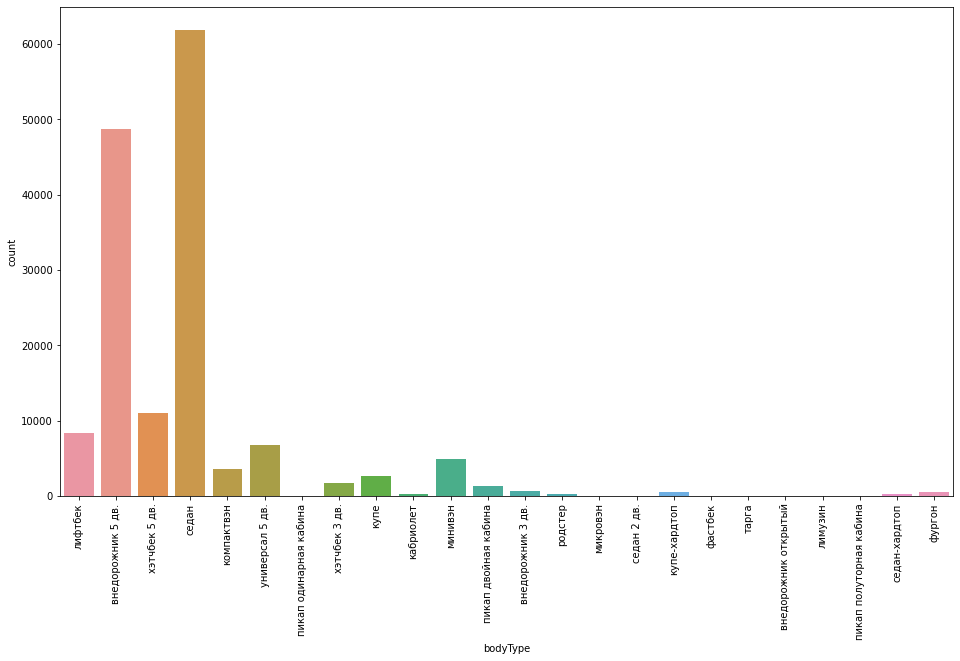

In [60]:
countplot('bodyType', data)

–ú–æ–∂–Ω–æ –≤—ã–¥–µ–ª–∏—Ç—å 5-7 –Ω–∞–∏–±–æ–ª–µ–µ —Ä–∞—Å–ø—Ä–æ—Å—Ç—Ä–∞–Ω–µ–Ω–Ω—ã—Ö —Ç–∏–ø–æ–≤ –∫—É–∑–æ–≤–æ–≤.

__–ò–¥–µ—è:__ –æ–±—ä–µ–¥–∏–Ω–∏—Ç—å —Ä–µ–¥–∫–∏–µ —Ç–∏–ø—ã –≤ –æ–¥–∏–Ω –∏–ª–∏ –∑–∞–º–µ–Ω–∏—Ç—å –Ω–∞ —Å–∞–º—ã–µ —Ä–∞—Å–ø—Ä–æ—Å—Ç—Ä–∞–Ω–µ–Ω–Ω—ã–µ

__–í—ã–≤–æ–¥:__ —Å–¥–µ–ª–∞–µ–º dummie-–ø–µ—Ä–µ–º–µ–Ω–Ω—ã–µ, –ø–æ—ç–∫—Å–ø–µ—Ä–µ–º–µ–Ω—Ç–∏—Ä—É–µ–º —Å –æ–±—ä–µ–¥–∏–Ω–µ–Ω–∏–µ–º

#### 6.2. brand

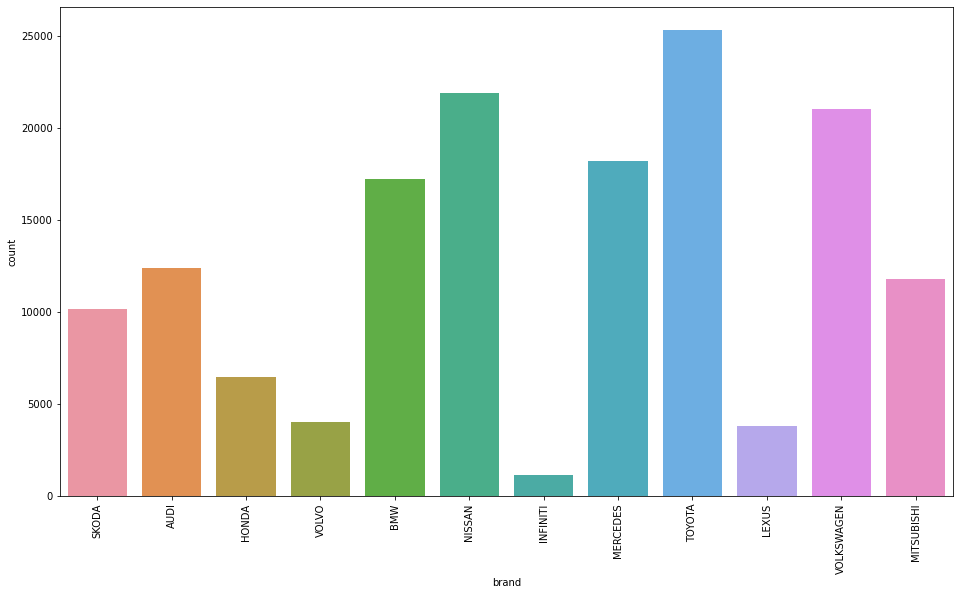

In [61]:
countplot('brand', data)

–ú–æ–∂–Ω–æ –≤—ã–¥–µ–ª–∏—Ç—å 3-4 –Ω–∞–∏–º–µ–Ω–µ–µ —Ä–∞—Å–ø—Ä–æ—Å—Ç—Ä–∞–Ω–µ–Ω–Ω—ã—Ö –±—Ä–µ–Ω–¥–æ–≤.

__–ò–¥–µ—è:__ –æ—Ü–µ–Ω–∏—Ç—å –≤–ª–∏—è–Ω–∏–µ –Ω–µ—Ä–∞–≤–Ω–æ–º–µ—Ä–Ω–æ–≥–æ –ø—Ä–µ–¥—Å—Ç–∞–≤–ª–µ–Ω–∏—è –º–æ–¥–µ–ª–µ–π –≤ –≤—ã–±–æ—Ä–∫–µ. –í–æ–∑–º–æ–∂–Ω–æ, –Ω—É–∂–Ω–æ –≤—ã—Ä–æ–≤–Ω—è—Ç—å —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω—É—é –≤—ã–±–æ—Ä–∫—É –ø–æ —á–∏—Å–ª—É –ø—Ä–µ–¥—Å—Ç–∞–≤–ª–µ–Ω–Ω—ã—Ö –º–æ–¥–µ–ª–µ–π.

__–í—ã–≤–æ–¥:__ —Å–¥–µ–ª–∞–µ–º dummie-–ø–µ—Ä–µ–º–µ–Ω–Ω—ã–µ, –≤–æ–ø—Ä–æ—Å –∫ —ç–∫—Å–ø–µ—Ä—Ç–∞–º –ø–æ –≤—ã–±–æ—Ä–∫–µ

#### 6.3. color

In [62]:
# –ó–∞–ø–æ–ª–Ω–µ–Ω–∏–µ –ø—Ä–æ–ø—É—Å–∫–æ–≤ –≤ 'color' —Å–∞–º—ã–º –ø–æ–ø—É–ª—è—Ä–Ω—ã–º –∑–Ω–∞—á–µ–Ω–∏–µ–º
col = 'color'
data[col] = data[col].fillna(data[col].mode()[0])

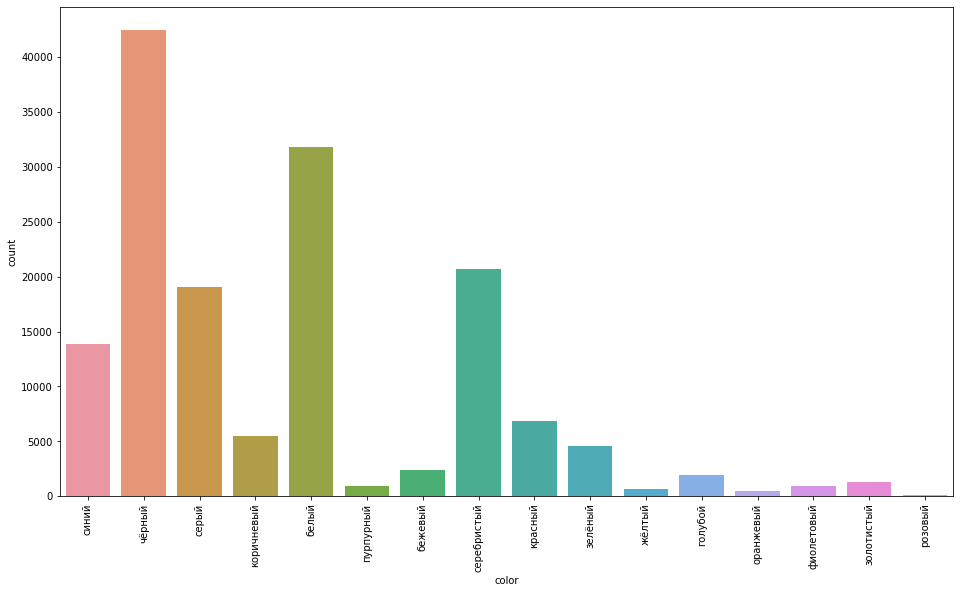

In [63]:
countplot(col, data)

–ú–æ–∂–Ω–æ –≤—ã–¥–µ–ª–∏—Ç—å 5 –Ω–∞–∏–±–æ–ª–µ–µ —Ä–∞—Å–ø—Ä–æ—Å—Ç—Ä–∞–Ω–µ–Ω–Ω—ã—Ö —Ü–≤–µ—Ç–æ–≤.

__–ò–¥–µ—è:__ –Ω–∞ –æ—Å–Ω–æ–≤–µ 'color' —Å–¥–µ–ª–∞—Ç—å –±–∏–Ω–∞—Ä–Ω—É—é –ø–µ—Ä–µ–º–µ–Ω–Ω—É—é - —è–≤–ª—è–µ—Ç—Å—è/–Ω–µ—Ç –ø–æ–ø—É–ª—è—Ä–Ω—ã–º —Ü–≤–µ—Ç–æ–º

__–í—ã–≤–æ–¥:__ —Å–¥–µ–ª–∞–µ–º dummie-–ø–µ—Ä–µ–º–µ–Ω–Ω—ã–µ, –ø–æ—ç–∫—Å–ø–µ—Ä–µ–º–µ–Ω—Ç–∏—Ä—É–µ–º —Å –Ω–æ–≤–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π

#### 6.4. description

In [64]:
# –ù–∞ –æ—Å–Ω–æ–≤–µ description –≤–≤–µ–¥–µ–º –Ω–æ–≤—É—é –ø–µ—Ä–µ–º–µ–Ω–Ω—É—é –∏—Å—Ö–æ–¥—è –∏–∑ –¥–ª–∏–Ω—ã –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏—è –ø—Ä–æ–¥–∞–≤—Ü–∞
col = 'description'
data[col] = data[col].apply(lambda x: len(str(x)))
data[col] = pd.qcut(data[col], 4, labels=[1, 2, 3, 4])

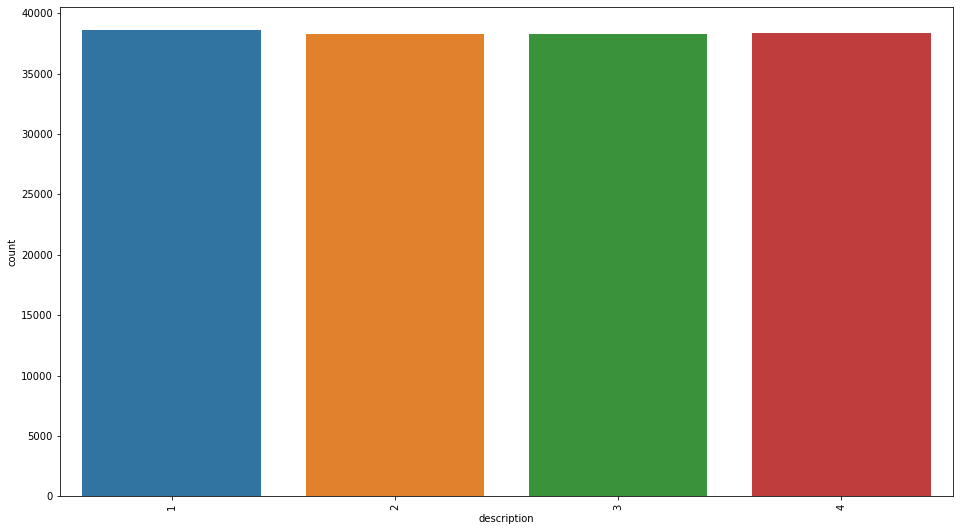

In [65]:
countplot(col, data)

–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∑–Ω–∞—á–µ–Ω–∏–π –ø—Ä–∏–º–µ—Ä–Ω–æ —Ä–∞–≤–Ω–æ–º–µ—Ä–Ω–æ–µ. 

__–í—ã–≤–æ–¥:__ –ø—Ä–æ–≤–µ—Ä–∏–º –∫–æ—Ä—Ä–µ–ª—è—Ü–∏—é —ç—Ç–æ–≥–æ –ø–∞—Ä–∞–º–µ—Ç—Ä–∞ –∏ –≤–∞–∂–Ω–æ—Å—Ç—å. –í–æ–∑–º–æ–∂–Ω–æ, –ø—Ä–∏–¥–µ—Ç—Å—è —É–¥–∞–ª–∏—Ç—å —ç—Ç—É –ø–µ—Ä–µ–º–µ–Ω–Ω—É—é.

#### 6.5. engineDisplacement

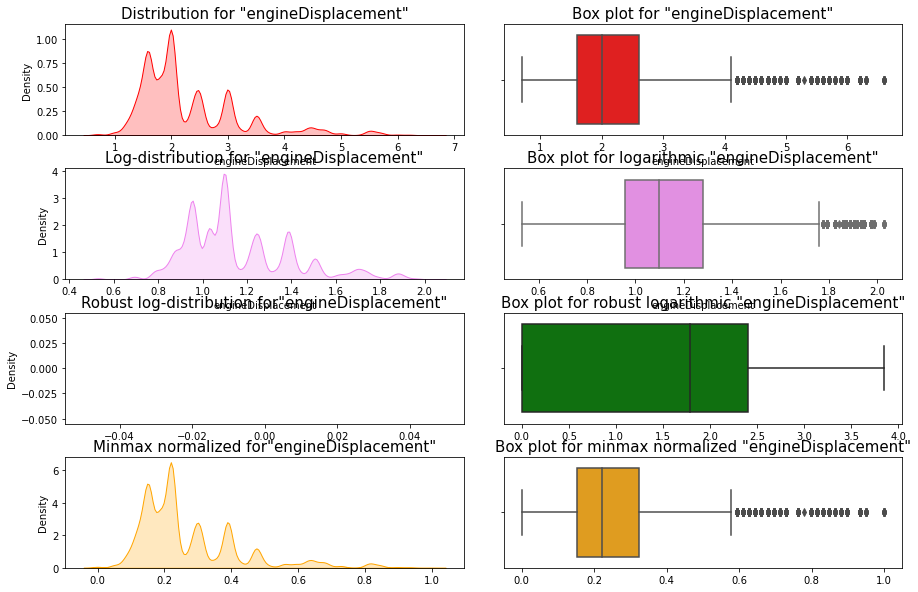

In [66]:
 dist_box(data, 'engineDisplacement')

In [67]:
# –ó–∞–ø–æ–ª–Ω–µ–Ω–∏–µ –ø—Ä–æ–ø—É—Å–∫–æ–≤ –≤ 'engineDisplacement' —á–µ—Ä–µ–∑ –º–æ—â–Ω–æ—Å—Ç—å –¥–≤–∏–≥–∞—Ç–µ–ª—è, –∫–æ—Ç–æ—Ä–∞—è –∏–∑–≤–µ—Å—Ç–Ω–∞ –∏ 
# —Å—Ä–∞–≤–Ω–µ–Ω–∏—é –ø–æ—Ö–æ–∂–µ–π –ø–æ –¥—Ä—É–≥–∏–º —Å—Ç—Ä–æ–∫–∞–º.
col_1 = 'engineDisplacement'
col_2 = 'enginePower'
index_list = data.index[data[col_1].isna()].tolist()
for idx in index_list:
    engine_power = data[col_2][idx]
    index_eng_power = data.index[(data[col_2] < engine_power*1.1) & (data[col_2] > engine_power*0.9)].tolist()
    data[col_1][idx] = round(data[col_1][index_eng_power].median(), 1)
#     print(data[col_1][idx])
data[col_1] = data[col_1].fillna(data[col_1].mode()[0])

–ù–∞–∏–±–æ–ª–µ–µ —Ä–∞—Å–ø—Ä–æ—Å—Ç—Ä–∞–Ω–µ–Ω—ã 9 –∑–Ω–∞—á–µ–Ω–∏–π.

__–í—ã–≤–æ–¥:__ 
- –û–±—Ä–∞—Ç–∏—Ç—å –≤–Ω–∏–º–∞–Ω–∏–µ –Ω–∞ –∫–æ—Ä–µ–ª–ª—è—Ü–∏—é —Å –º–æ—â–Ω–æ—Å—Ç—å—é –¥–≤–∏–≥–∞—Ç–µ–ª—è (–ø—Ä–µ–¥–ø–æ–ª–æ–∂–∏—Ç–µ–ª—å–Ω–æ –±—É–¥–µ—Ç –≤—ã—Å–æ–∫–∞—è). 
- –í–æ–∑–º–æ–∂–Ω–æ –ø–æ—Ç—Ä–µ–±—É–µ—Ç—Å—è –¥–∏—Å–∫—Ä–µ—Ç–∏–∑–∞—Ü–∏—è –¥–∞–Ω–Ω–æ–≥–æ –ø—Ä–∏–∑–Ω–∞–∫–∞ (–≤ —ç—Ç–æ–º —Å–ª—É—á–∞–µ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å stratagy='kmeans').
- –ò–ª–∏ –Ω–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—è min/max.
- –í—ã–±—Ä–æ—Å—ã –º–æ–∂–Ω–æ –ø—Ä–∏—Ä–∞–≤–Ω—è—Ç—å –∫ 4.0.

#### 6.6. enginePower

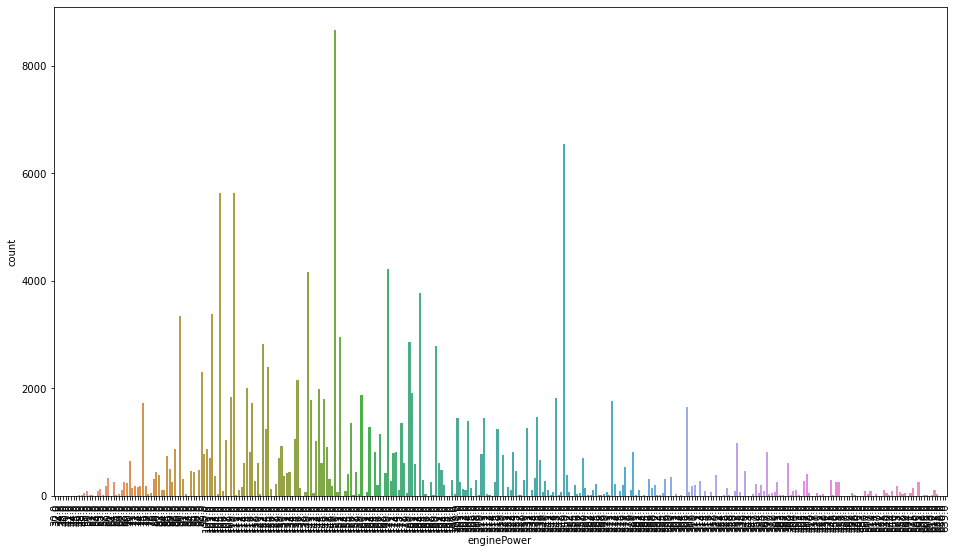

In [68]:
countplot('enginePower', data)

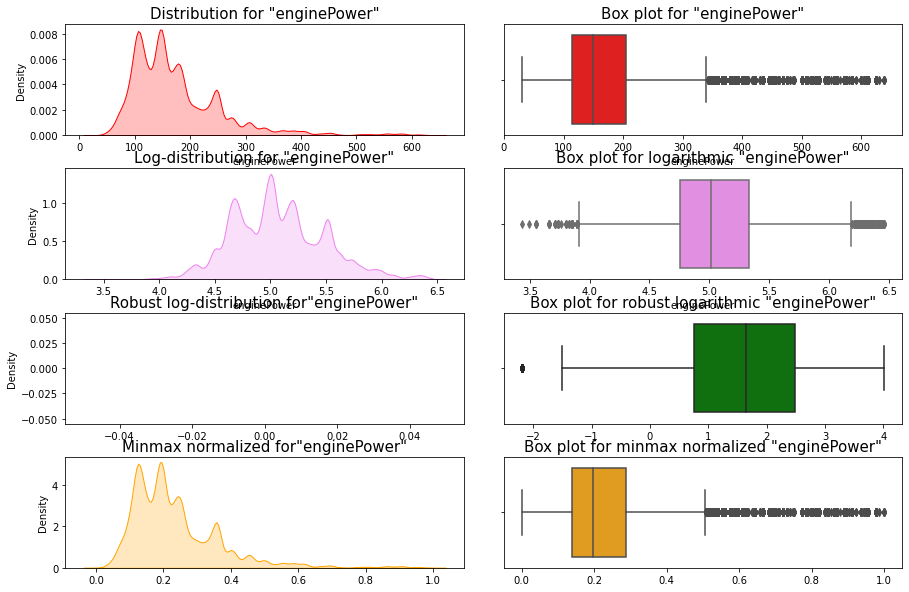

In [69]:
 dist_box(data, 'enginePower')

–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –¥–∞–Ω–Ω–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π —Å—Ö–æ–∂–µ —Å engineDisplacement. –í—ã–≤–æ–¥—ã —Ç–µ –∂–µ.

#### 6.7. fuelType

In [70]:
# –ó–∞–ø–æ–ª–Ω–µ–Ω–∏–µ –ø—Ä–æ–ø—É—Å–∫–æ–≤ fuelType –Ω–∞ —Å–∞–º—ã–π —Ä–∞—Å–ø—Ä–æ—Å—Ç—Ä–∞–Ω–µ–Ω–Ω—ã–π - '–±–µ–Ω–∑–∏–Ω'
col = 'fuelType'
data[col] = data[col].fillna(data[col].mode()[0])
data[col].value_counts()

–±–µ–Ω–∑–∏–Ω     126688
–¥–∏–∑–µ–ª—å      24620
–≥–∏–±—Ä–∏–¥       1752
—ç–ª–µ–∫—Ç—Ä–æ       464
–≥–∞–∑             7
Name: fuelType, dtype: int64

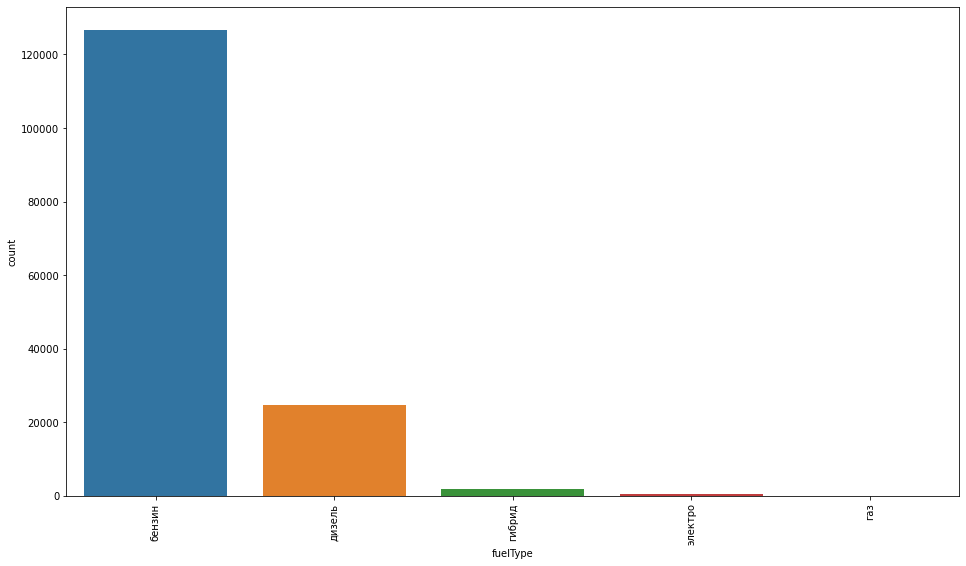

In [71]:
countplot(col, data)

In [72]:
data.loc[data[col]!='–≥–∞–∑', col] = '–±–µ–Ω–∑–∏–Ω'

–ó–Ω–∞—á–µ–Ω–∏–π "–≥–∞–∑" –≤—Å–µ–≥–æ 7, –ø–æ—ç—Ç–æ–º—É –ø—Ä–µ–¥–ª–∞–≥–∞—é —É–±—Ä–∞—Ç—å —ç—Ç–∏ —Å—Ç—Ä–æ–∫–∏ –∏–ª–∏ –∑–∞–º–µ–Ω–∏—Ç—å –Ω–∞ "–±–µ–Ω–∑–∏–Ω".

__–í—ã–≤–æ–¥:__ –°–æ–∑–¥–∞–µ–º dummie-–ø—Ä–∏–∑–Ω–∞–∫–∏.

#### 6.8. mileage

In [74]:
# –ó–∞–ø–æ–ª–Ω–µ–Ω–∏–µ –ø—Ä–æ–ø—É—Å–∫–æ–≤ –≤ 'mileage' —á–µ—Ä–µ–∑ –≥–æ–¥ –≤—ã–ø—É—Å–∫–∞, –∫–æ—Ç–æ—Ä—ã–π –∏–∑–≤–µ—Å—Ç–µ–Ω –∏ 
# —Å—Ä–∞–≤–Ω–µ–Ω–∏—é –ø–æ—Ö–æ–∂–µ–π –ø–æ –¥—Ä—É–≥–∏–º —Å—Ç—Ä–æ–∫–∞–º.
col_1 = 'mileage'
col_2 = 'productionDate'
index_list = data.index[(data[col_1] == 0.0) | (data[col_1].isna())].tolist()
for idx in index_list:
    year = data[col_2][idx]
    if year == 2021:
        data[col_1][idx] = 1000
    else:
        index_year_list = data.index[data[col_2] == year].tolist()
        data[col_1][idx] = round(data[col_1][index_year_list].mean())
    print(data[col_1][idx])

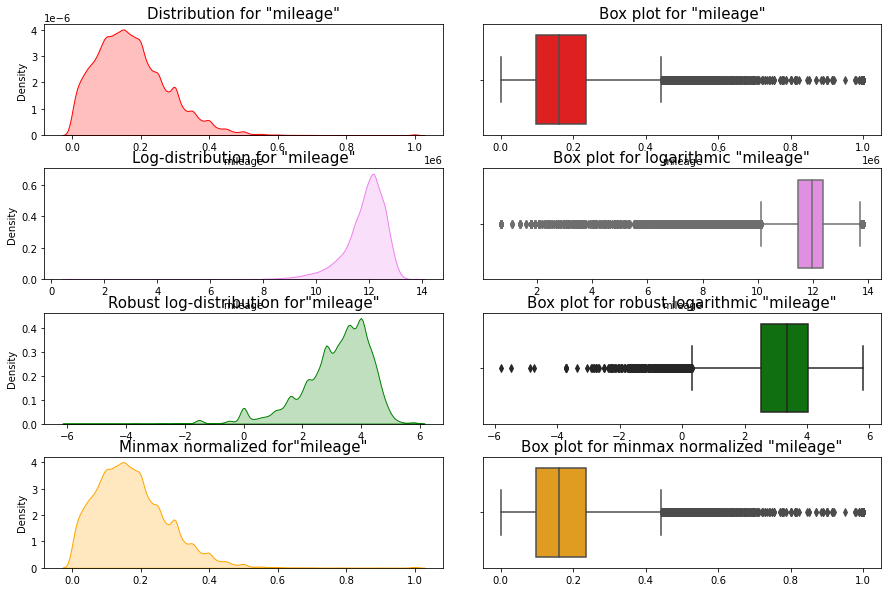

In [75]:
dist_box(data, col_1)

__–í—ã–≤–æ–¥:__ 
- –ó–Ω–∞—á–µ–Ω–∏—è > 500 000 –ø—Ä–∏—Ä–∞–≤–Ω–∏–≤–∞–µ–º –∫ 500 000;
- –í–æ–∑–º–æ–∂–Ω–æ –ø—Ä–∏–≥–æ–¥–∏—Ç—Å—è –¥–∏—Å–∫—Ä–µ—Ç–∏–∑–∞—Ü–∏—è –¥–∞–Ω–Ω–æ–≥–æ –ø—Ä–∏–∑–Ω–∞–∫–∞;
- –ò–ª–∏ –Ω–æ—Ä–º–∞–ª–∏–∑—É–µ–º –∫ –¥–∏–∞–ø–∞–∑–æ–Ω—É (0, 1) –º–µ—Ç–æ–¥–æ–º min/max. –†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –ø–æ—Ö–æ–∂–µ –Ω–∞ –Ω–æ—Ä–º–∞–ª—å–Ω–æ–µ. 

#### 6.9. model_name

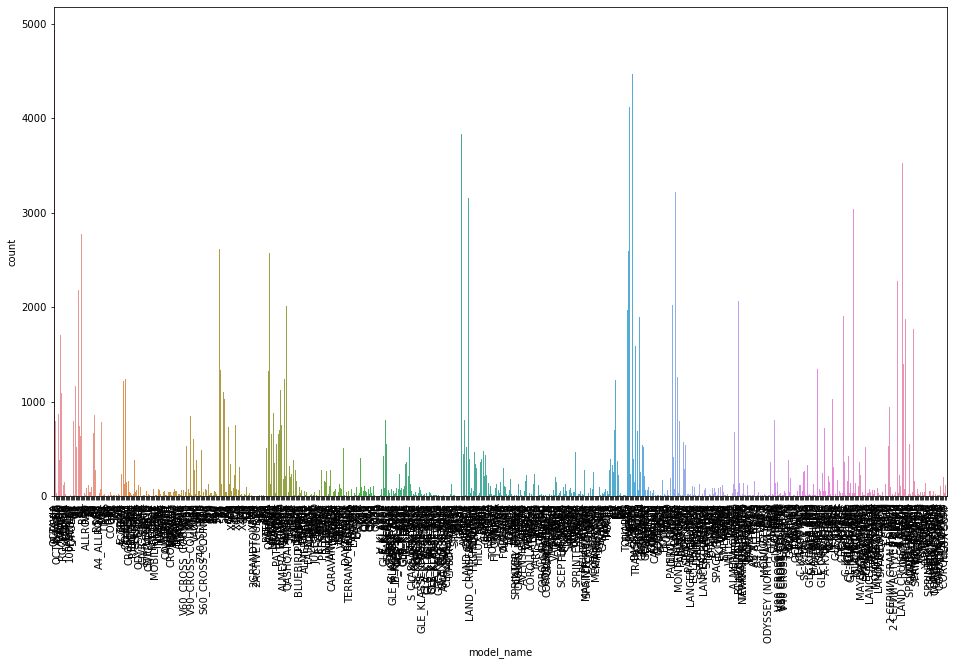

In [76]:
countplot('model_name', data)

__–í—ã–≤–æ–¥:__ 
- –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –∑–Ω–∞—á–µ–Ω–∏–π –ø–æ –º–æ–¥–µ–ª—è–º –Ω–µ —Ä–∞–≤–Ω–æ–º–µ—Ä–Ω–æ–µ, –Ω—É–∂–Ω–æ —ç—Ç–æ —É—á–µ—Å—Ç—å –ø—Ä–∏ –≤–∞–ª–∏–¥–∞—Ü–∏–∏;
- –ò—Å–ø–æ–ª—å–∑—É–µ–º OneHotEncoding.

#### 6.10. parsing_unixtime & productionDate
–î–∞–Ω–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ –º–æ–∂–Ω–æ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å –¥–ª—è –≤—ã—á–∏—Å–ª–µ–Ω–∏—è –ø–µ—Ä–∏–æ–¥–∞ –≤—Ä–µ–º–µ–Ω–∏ —Å –º–æ–º–µ–Ω—Ç–∞ –ø—Ä–æ–∏–∑–≤–æ–¥—Å—Ç–≤–∞ –∞–≤—Ç–æ–º–æ–±–∏–ª—è, —Ç.–∫. –≥–æ–¥ —Å–æ—Å—Ç–∞–≤–ª–µ–Ω–∏—è —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω–æ–≥–æ –∏ —Ç–µ—Å—Ç–æ–≤–æ–≥–æ –¥–∞—Ç–∞—Å–µ—Ç–æ–≤ –æ—Ç–ª–∏—á–∞—é—Ç—Å—è.

In [77]:
# #–ü—Ä–∏–≤–µ–¥–µ–Ω–∏–µ –≤—Ä–µ–º–µ–Ω–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –∫ –µ–¥–∏–Ω–æ–º—É —Ñ–æ—Ä–º–∞—Ç—É
# data['parsing_unixtime'] = pd.to_datetime(data['parsing_unixtime'], unit='s')
# data['parsing_unixtime'] = pd.DatetimeIndex(data['parsing_unixtime']).year
# data['productionDate'] = pd.to_datetime(data['productionDate'], format='%Y')
# data['productionDate'] = pd.DatetimeIndex(data['productionDate']).year

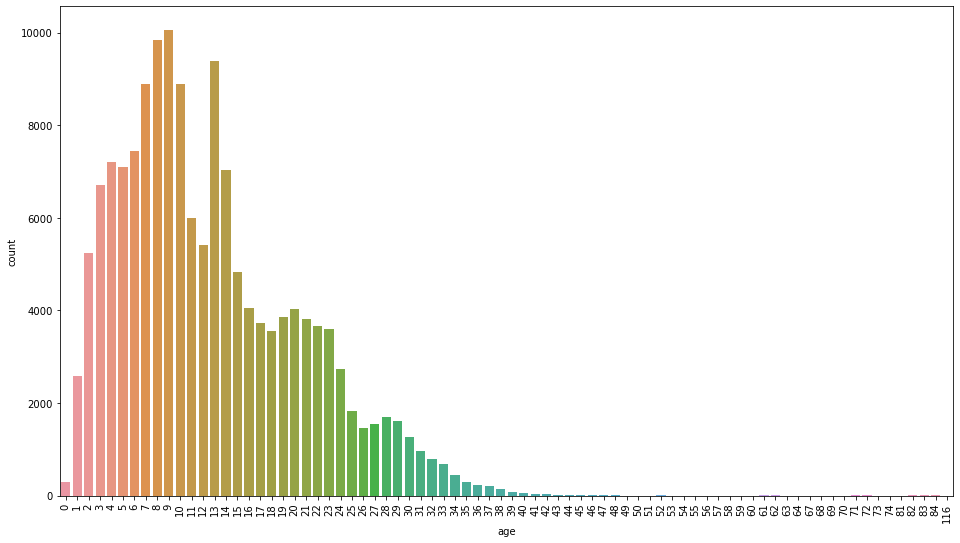

In [78]:
data['age'] = data['parsing_unixtime'] - data['productionDate']
countplot('age', data)

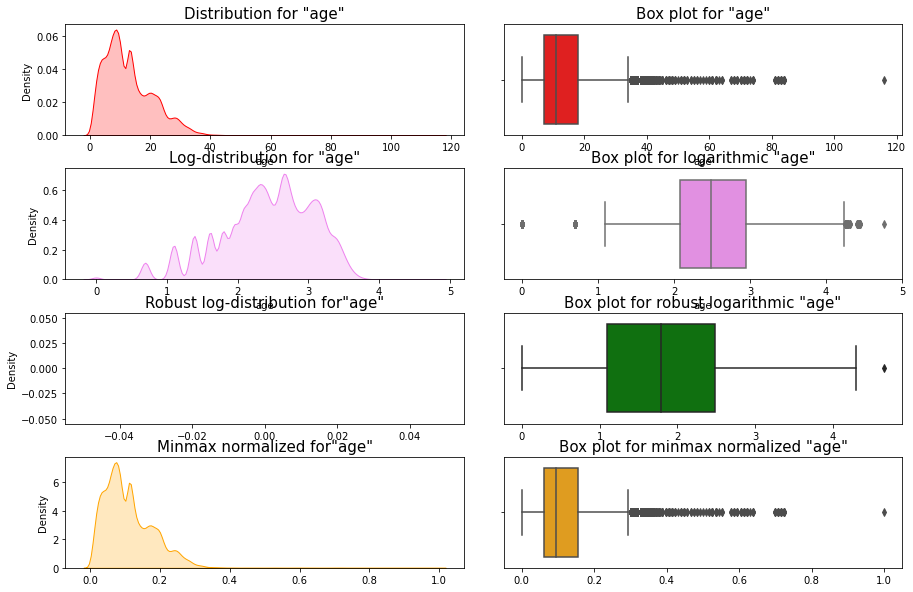

In [79]:
dist_box(data, 'age')

__–í—ã–≤–æ–¥:__ 
- –ù–æ–≤—ã–π –ø—Ä–∏–∑–Ω–∞–∫ –Ω–∞ –∏—Ö –æ—Å–Ω–æ–≤–µ: age - –∫–æ–ª-–≤–æ –ª–µ—Ç —Å –¥–∞—Ç—ã –ø—Ä–æ–∏–∑–≤–æ–¥—Å—Ç–≤–∞ –∫ –≥–æ–¥—É –ø–∞—Ä—Å–∏–Ω–≥–∞;
- –£–¥–∞–ª—è–µ–º –æ–±–∞ —Å—Ç–∞—Ä—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–∞;
- –ó–Ω–∞—á–µ–Ω–∏—è 'age' —Å–≤—ã—à–µ 35 –ø—Ä–∏—Ä–∞–≤–Ω–∏–≤–∞–µ–º –∫ 35;
- –ü–æ –≥—Ä–∞—Ñ–∏–∫—É –º–æ–∂–Ω–æ –æ—Ç—Å–ª–µ–¥–∏—Ç—å –∫—Ä–∏–∑–∏—Å–Ω—ã–µ —è–≤–ª–µ–Ω–∏—è –≤ —ç–∫–æ–Ω–æ–º–∏–∫–µ. –°–Ω–∏–∂–µ–Ω–∏–µ –∫–æ–ª-–≤–∞ –∞–≤—Ç–æ–º–æ–±–∏–ª–µ–π 11-12 –ª–µ—Ç –≤ –ø—Ä–æ–¥–∞–∂–µ —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É–µ—Ç –∫—Ä–∏–∑–∏—Å—É 2008-2010 –≥–æ–¥–∞;
- –ù–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—è min/max —Ç–æ–∂–µ –ø–æ—Ç—Ä–µ–±—É–µ—Ç—Å—è.

#### 6.11. vehicleTransmission

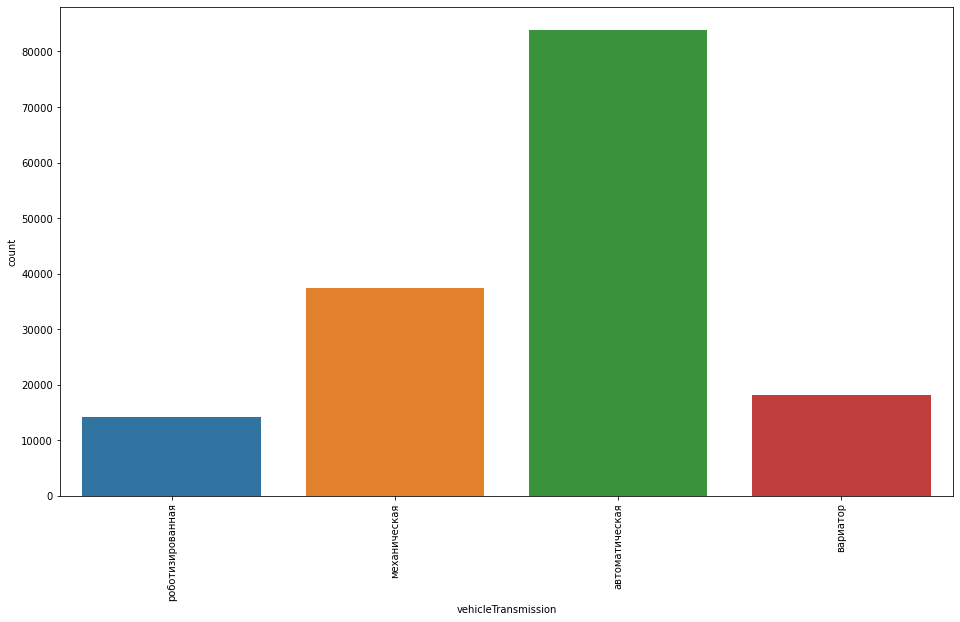

In [80]:
countplot('vehicleTransmission', data)

__–í—ã–≤–æ–¥:__ 
–í—Å–µ —Ö–æ—Ä–æ—à–æ —Å –¥–∞–Ω–Ω—ã–º –ø—Ä–∏–∑–Ω–∞–∫–æ–º. –ò—Å–ø–æ–ª—å–∑—É–µ–º OneHotEncoding.

#### 6.12. vendor

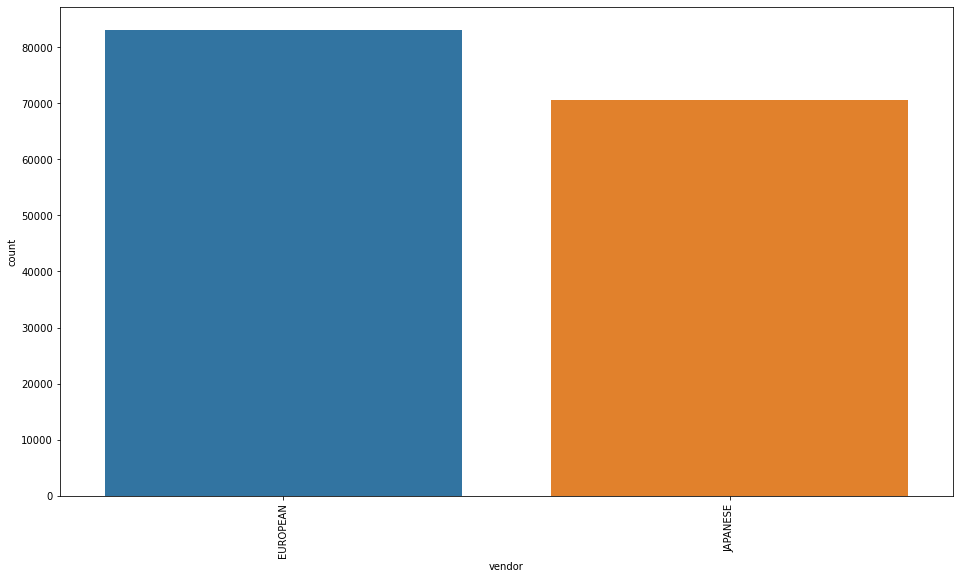

In [81]:
countplot('vendor', data)

__–í—ã–≤–æ–¥:__
–í—Å–µ —Ö–æ—Ä–æ—à–æ —Å –¥–∞–Ω–Ω—ã–º –ø—Ä–∏–∑–Ω–∞–∫–æ–º. –ò—Å–ø–æ–ª—å–∑—É–µ–º OneHotEncoding.

#### 6.13. –í–ª–∞–¥–µ–ª—å—Ü—ã
–ü—Ä–æ–ø—É—Å–∫–∏ –º–µ–Ω—è–µ–º –Ω–∞ –∑–Ω–∞—á–µ–Ω–∏–µ 3 (3 –∏ –±–æ–ª—å—à–µ).

In [82]:
col = '–í–ª–∞–¥–µ–ª—å—Ü—ã'
data[col] = data[col].fillna(3.0)

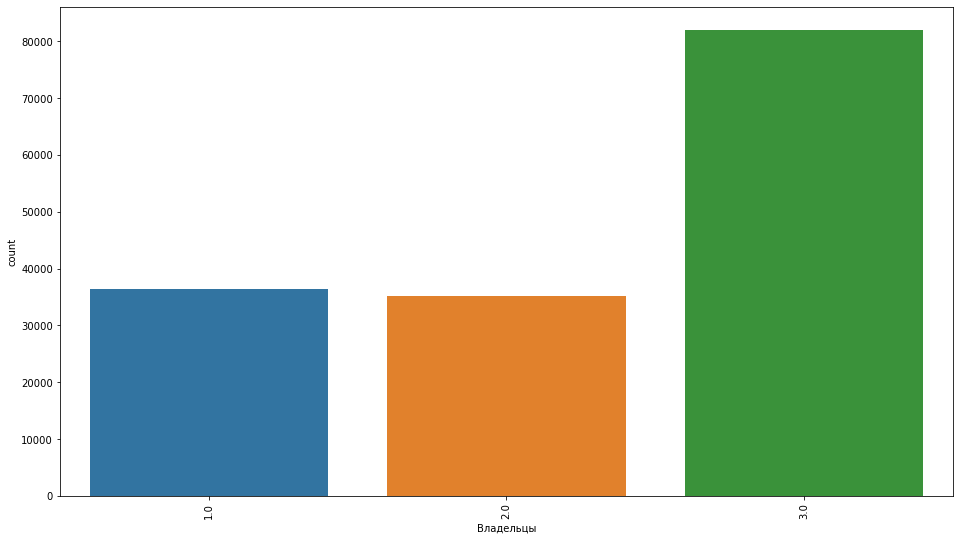

In [83]:
countplot('–í–ª–∞–¥–µ–ª—å—Ü—ã', data)

__–í—ã–≤–æ–¥:__
–í—Å–µ —Ö–æ—Ä–æ—à–æ —Å –¥–∞–Ω–Ω—ã–º –ø—Ä–∏–∑–Ω–∞–∫–æ–º. –ò—Å–ø–æ–ª—å–∑—É–µ–º OneHotEncoding.

#### 6.14. –í–ª–∞–¥–µ–Ω–∏–µ
–ó–∞–ø–æ–ª–Ω–µ–Ω–∏–µ –ø—Ä–æ–ø—É—Å–∫–æ–≤ –≤ '–í–ª–∞–¥–µ–Ω–∏–µ' —á–µ—Ä–µ–∑ –≥–æ–¥ –≤—ã–ø—É—Å–∫–∞, –∫–æ—Ç–æ—Ä—ã–π –∏–∑–≤–µ—Å—Ç–µ–Ω –∏ —Å—Ä–∞–≤–Ω–µ–Ω–∏—é –ø–æ—Ö–æ–∂–µ–π –ø–æ –¥—Ä—É–≥–∏–º —Å—Ç—Ä–æ–∫–∞–º. –û—Å—Ç–∞–≤—à–∏–µ—Å—è –ø—Ä–æ–ø—É—Å–∫–∏ –¥–ª—è —Ä–µ–¥–∫–∏—Ö –∏ —Å—Ç–∞—Ä—ã—Ö –∞–≤—Ç–æ–º–æ–±–∏–ª–µ–π –∑–∞–ø–æ–ª–Ω–∏–º —Å–∞–º—ã–º —Ä–∞—Å–ø—Ä–æ—Å—Ç—Ä–∞–Ω–µ–Ω–Ω—ã–º –∑–Ω–∞—á–µ–Ω–∏–µ–º.

In [84]:
col_1 = '–í–ª–∞–¥–µ–Ω–∏–µ'
col_2 = 'productionDate'
index_list = data.index[(data[col_1].isna()) | (data[col_1] == 0.0)].tolist()
for idx in index_list:
    year = data[col_2][idx]
    index_year_list = data.index[data[col_2] == year].tolist()
    data[col_1][idx] = round(data[col_1][index_year_list].median(), 2)
#     print(data[col_1][idx])

data[col_1] = data[col_1].fillna(data[col_1].mode()[0])

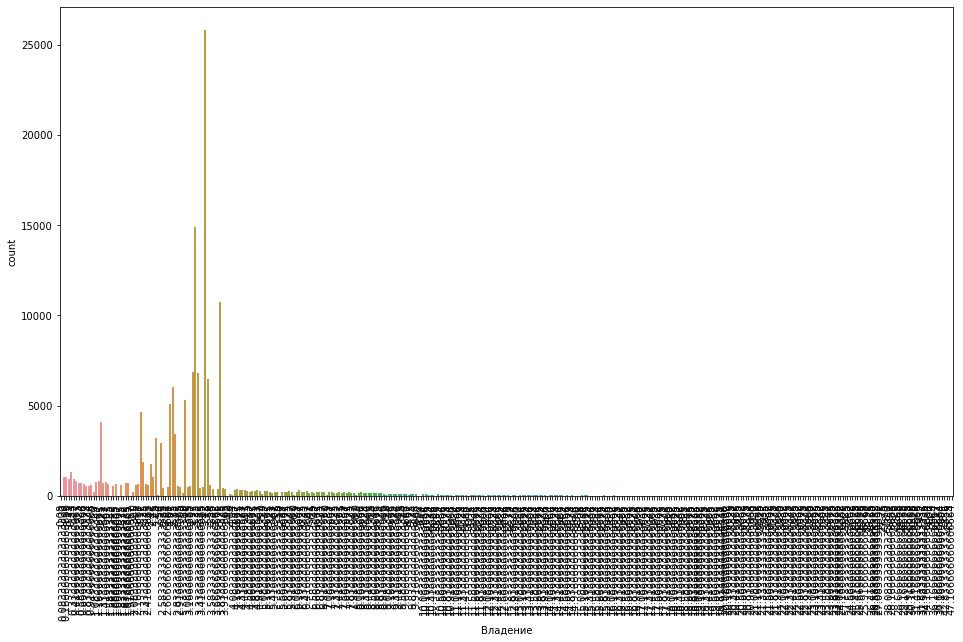

In [85]:
countplot('–í–ª–∞–¥–µ–Ω–∏–µ', data)

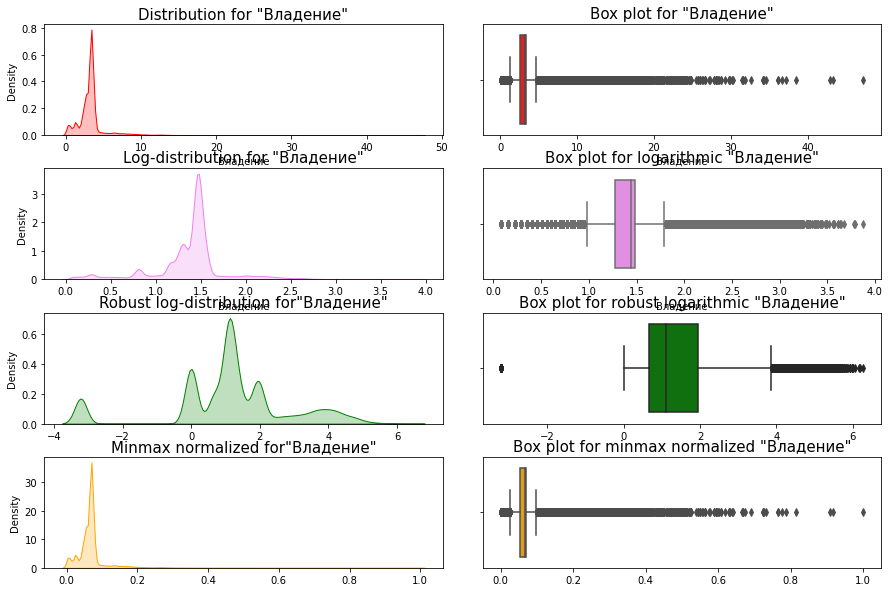

In [86]:
dist_box(data, '–í–ª–∞–¥–µ–Ω–∏–µ')

__–í—ã–≤–æ–¥:__ 
- –†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω –Ω–æ—Ä–º–∞–ª—å–Ω–æ, –±–æ–ª—å—à–æ–π —Ö–≤–æ—Å—Ç —Å–ø—Ä–∞–≤–∞;
- –£–¥–∞–ª—è–µ–º –æ–±–∞ —Å—Ç–∞—Ä—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–∞;
- –õ–∏–±–æ –∑–Ω–∞—á–µ–Ω–∏—è —Å–≤—ã—à–µ 5 –ø—Ä–∏—Ä–∞–≤–Ω–∏–≤–∞–µ–º –∫ 5. –ó–∞—Ç–µ–º –Ω–æ—Ä–º–∞–ª–∏–∑—É–µ–º min/max;
- –õ–∏–±–æ –¥–∏—Å–∫—Ä–µ–¥–∏—Ç–∏–∑–∞—Ü–∏—è —Å OneHotEncoding;

#### 6.15. –ü–¢–°
–î–≤–∞ –≤–∞—Ä–∏–∞–Ω—Ç–∞: –æ—Ä–∏–≥–∏–Ω–∞–ª, –¥—É–±–ª–∏–∫–∞—Ç. NaN –ø—Ä–µ–¥–ª–∞–≥–∞—é –∑–∞–º–µ–Ω–∏—Ç—å –Ω–∞ "–¥—É–±–ª–∏–∫–∞—Ç".

In [87]:
col = '–ü–¢–°'
data[col] = data[col].fillna('–î—É–±–ª–∏–∫–∞—Ç')

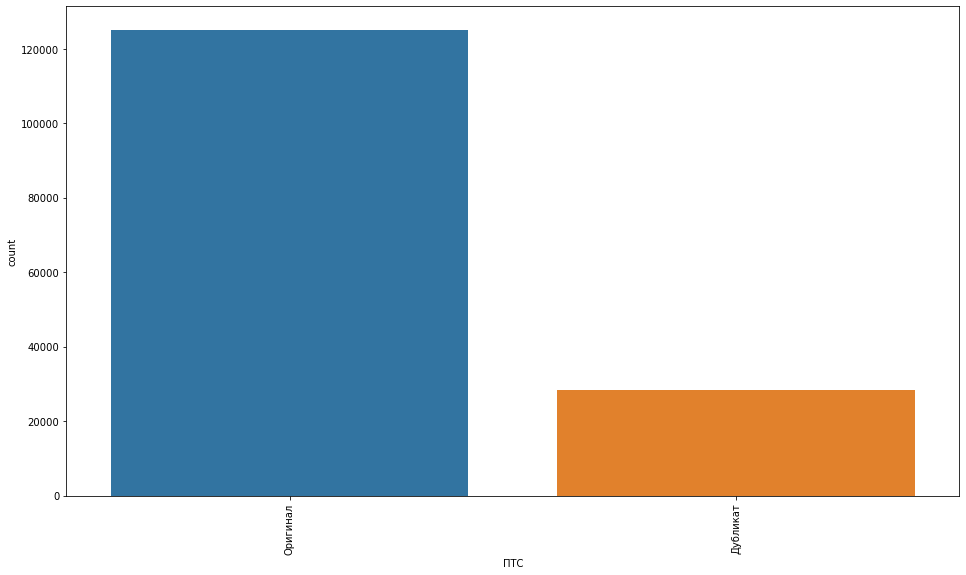

In [88]:
countplot(col, data)

__–í—ã–≤–æ–¥:__ –í—Å–µ —Ö–æ—Ä–æ—à–æ —Å –¥–∞–Ω–Ω—ã–º –ø—Ä–∏–∑–Ω–∞–∫–æ–º. –ò—Å–ø–æ–ª—å–∑—É–µ–º OneHotEncoding.

#### 6.16. –ü—Ä–∏–≤–æ–¥
–ó–∞–ø–æ–ª–Ω–µ–Ω–∏–µ –ø—Ä–æ–ø—É—Å–∫–æ–≤ –≤ '–ü—Ä–∏–≤–æ–¥' —á–µ—Ä–µ–∑ –Ω–∞–∑–≤–∞–Ω–∏–µ –º–æ–¥–µ–ª–∏, –∫–æ—Ç–æ—Ä—ã–π –∏–∑–≤–µ—Å—Ç–µ–Ω –∏ —Å—Ä–∞–≤–Ω–µ–Ω–∏—é –ø–æ—Ö–æ–∂–µ–π –ø–æ –¥—Ä—É–≥–∏–º —Å—Ç—Ä–æ–∫–∞–º.

In [89]:
col_1 = '–ü—Ä–∏–≤–æ–¥'
col_2 = 'model_name'
index_list = data.index[data[col_1].isna()].tolist()
for idx in index_list:
    model = data[col_2][idx]
    index_model_list = data.index[data[col_2] == model].tolist()
    model_series = data[col_1][index_model_list].loc[~data[col_1][index_model_list].isnull()]
    if len(model_series) == 0:
        data[col_1][idx] = '–ø–µ—Ä–µ–¥–Ω–∏–π'
    else:
        data[col_1][idx] = mode(model_series)
#     print(data[col_1][idx])

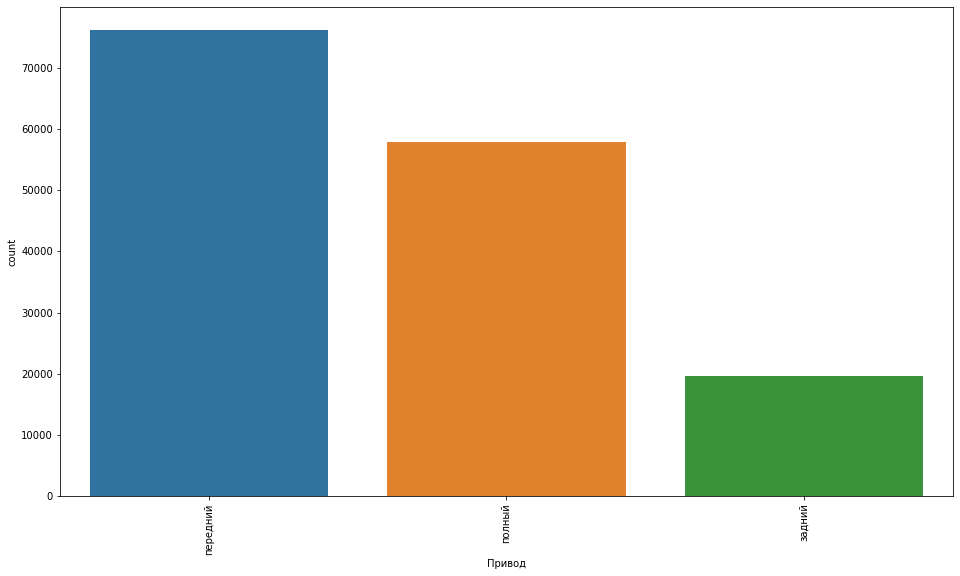

In [90]:
countplot('–ü—Ä–∏–≤–æ–¥', data)

__–í—ã–≤–æ–¥:__ –í—Å–µ —Ö–æ—Ä–æ—à–æ —Å –¥–∞–Ω–Ω—ã–º –ø—Ä–∏–∑–Ω–∞–∫–æ–º. –ò—Å–ø–æ–ª—å–∑—É–µ–º OneHotEncoding.

#### 6.17. –†—É–ª—å
–ó–∞–ø–æ–ª–Ω–µ–Ω–∏–µ –ø—Ä–æ–ø—É—Å–∫–æ–≤ –≤ '–†—É–ª—å' —á–µ—Ä–µ–∑ –Ω–∞–∑–≤–∞–Ω–∏–µ –º–æ–¥–µ–ª–∏, –∫–æ—Ç–æ—Ä—ã–π –∏–∑–≤–µ—Å—Ç–µ–Ω –∏ —Å—Ä–∞–≤–Ω–µ–Ω–∏—é –ø–æ—Ö–æ–∂–µ–π –ø–æ –¥—Ä—É–≥–∏–º —Å—Ç—Ä–æ–∫–∞–º.

In [91]:
col_1 = '–†—É–ª—å'
col_2 = 'model_name'
index_list = data.index[data[col_1].isna()].tolist()
for idx in index_list:
    model = data[col_2][idx]
    index_model_list = data.index[data[col_2] == model].tolist()
    model_series = data[col_1][index_model_list].loc[~data[col_1][index_model_list].isnull()]
    if len(model_series) == 0:
        data[col_1][idx] = '–ü—Ä–∞–≤—ã–π'
    else:
        data[col_1][idx] = mode(model_series)
#     print(data[col_1][idx])

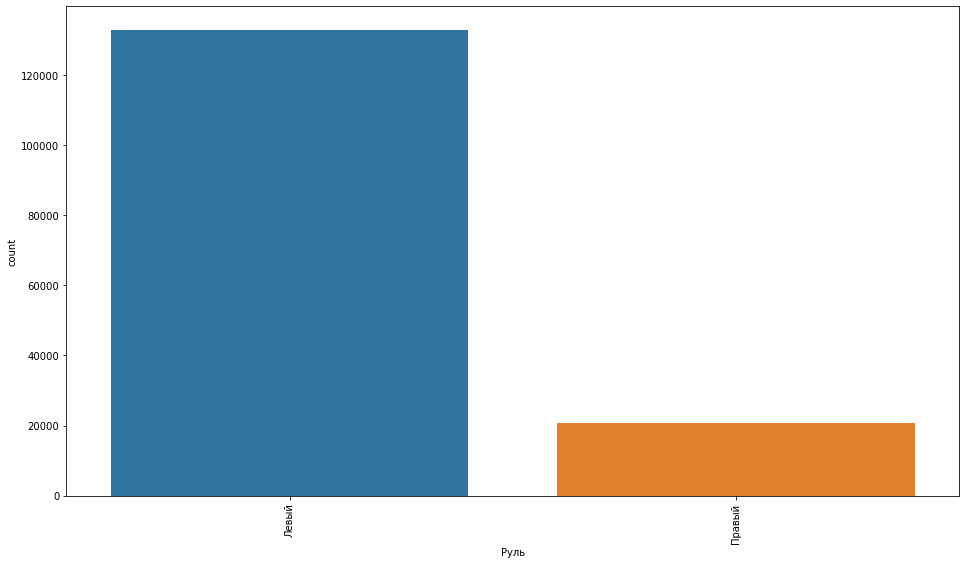

In [92]:
countplot('–†—É–ª—å', data)

__–í—ã–≤–æ–¥:__ –í—Å–µ —Ö–æ—Ä–æ—à–æ —Å –¥–∞–Ω–Ω—ã–º –ø—Ä–∏–∑–Ω–∞–∫–æ–º. –ò—Å–ø–æ–ª—å–∑—É–µ–º OneHotEncoding.

#### 6.18. Price

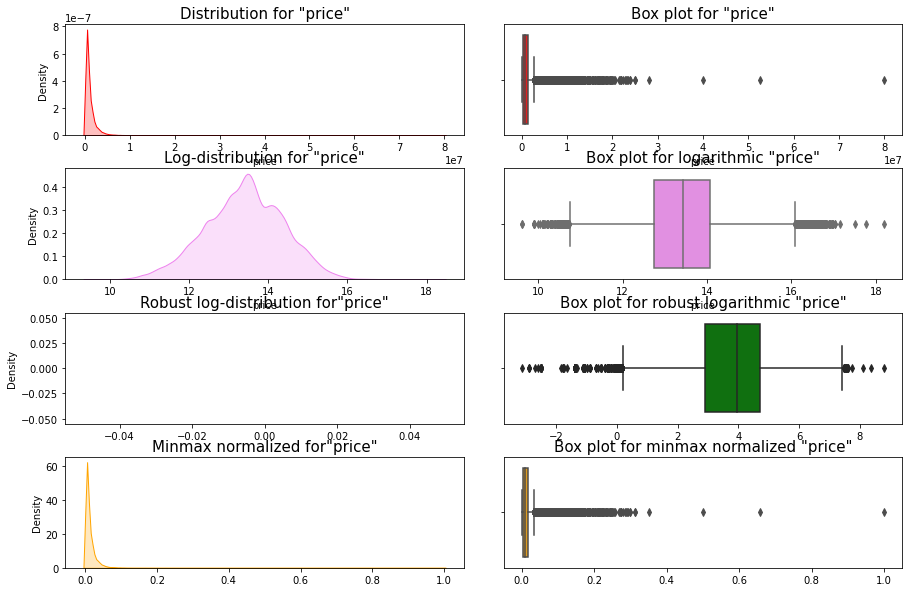

In [93]:
dist_box(data, 'price')

### 7. Feature Engineering

#### 7.1. –ü—Ä–∏—Ä–∞–≤–Ω–∏–≤–∞–Ω–∏–µ –≤—ã–±—Ä–æ—Å–æ–≤ –∫ –≥—Ä–∞–Ω–∏—Ü–µ 3 –∫–≤–∞—Ä—Ç–∏–ª–∏

In [94]:
data.loc[data['engineDisplacement'] >= 4, 'engineDisplacement'] = 4
data.loc[data['mileage'] >= 500000, 'mileage'] = 500000
data.loc[data['age'] >= 35, 'age'] = 35
data.loc[data['–í–ª–∞–¥–µ–Ω–∏–µ'] >= 5, '–í–ª–∞–¥–µ–Ω–∏–µ'] = 5

#### 7.2. –ù–æ–≤—ã–π –ø—Ä–∏–∑–Ω–∞–∫ age.
–†–∞–∑–Ω–∏—Ü–∞ –¥–∞—Ç –ø—Ä–æ–∏–∑–≤–æ–¥—Å—Ç–≤–∞ –∏ –ø–∞—Ä—Å–∏–Ω–≥–∞ –æ–±—ä—è–≤–ª–µ–Ω–∏—è.

In [95]:
# data['age'] = data['parsing_unixtime'] - data['productionDate']

In [96]:
data = data.drop(['parsing_unixtime', 'productionDate', ], axis=1) # –£–¥–∞–ª–∏–º –∏—Å—Ö–æ–¥–Ω—ã–µ —Å—Ç–æ–ª–±—Ü—ã

#### 7.3. –¢–∏–ø—ã –ø–µ—Ä–µ–º–µ–Ω–Ω—ã—Ö.

In [97]:
target = 'price'
cat_cols = ['bodyType', 'brand', 'color', 'description', 'fuelType', 'model_name', 'vehicleTransmission', 
             '–í–ª–∞–¥–µ–ª—å—Ü—ã', '–ü—Ä–∏–≤–æ–¥', 'vendor', '–ü–¢–°', '–†—É–ª—å']
num_cols = ['engineDisplacement', 'enginePower', 'mileage', 'age', '–í–ª–∞–¥–µ–Ω–∏–µ']

#### 7.4. –ü–µ—Ä–µ–≤–æ–¥ –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –≤ dummie.
–ó–∞–∫–æ–¥–∏—Ä—É–µ–º –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ –ø—Ä–∏ –ø–æ–º–æ—â–∏ get_dummy.

In [98]:
data_cat = pd.get_dummies(data.loc[:, cat_cols], columns = cat_cols)
data_cat.shape

(153531, 788)

#### 7.5. –ù–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—è —á–∏—Å–ª–æ–≤—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤.
–ü—Ä–∏–º–µ–Ω—è–µ–º min/max –Ω–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—é.

In [99]:
scaler = MinMaxScaler()
data_num_scaled = pd.DataFrame(scaler.fit_transform(data[num_cols]), columns = num_cols)

In [100]:
data_num_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153531 entries, 0 to 153530
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   engineDisplacement  153531 non-null  float64
 1   enginePower         153527 non-null  float64
 2   mileage             153531 non-null  float64
 3   age                 153531 non-null  float64
 4   –í–ª–∞–¥–µ–Ω–∏–µ            153531 non-null  float64
dtypes: float64(5)
memory usage: 5.9 MB


#### 7.6. –õ–æ–≥–∞—Ä–∏—Ñ–º–∏—Ä–æ–≤–∞–Ω–∏–µ —á–∏—Å–ª–æ–≤—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤.
–î—Ä—É–≥–æ–π –≤–∞—Ä–∏–∞–Ω—Ç –Ω–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏–∏. –ü–æ–∑–∂–µ —Å—Ä–∞–≤–Ω—é —ç—Ñ—Ñ–µ–∫—Ç–∏–≤–Ω–æ—Å—Ç—å.

In [101]:
data_num_log = pd.DataFrame()
for col in num_cols:
    data_num_log[col] = np.log(data[col])

#### 7.7. –î–∏—Å–∫—Ä–µ—Ç–∏–∑–∞—Ü–∏—è —á–∏—Å–ª–æ–≤—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤.
–¢—Ä–µ—Ç–∏–π –≤–∞—Ä–∏–∞–Ω—Ç –Ω–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏–∏. –î–∏—Å–∫—Ä–µ—Ç–∏–∑–∞—Ü–∏—è + get_dummies. –ü–æ–∑–∂–µ —Å—Ä–∞–≤–Ω—é —ç—Ñ—Ñ–µ–∫—Ç–∏–≤–Ω–æ—Å—Ç—å.

In [102]:
disc = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='kmeans')
data_num_disc = pd.DataFrame(disc.fit_transform(data[num_cols]), columns = num_cols)
data_num_disc = pd.get_dummies(data_num_disc, columns = num_cols)
data_num_disc.shape

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

### 8. –ö–æ—Ä—Ä–µ–ª—è—Ü–∏–æ–Ω–Ω—ã–π –∞–Ω–∞–ª–∏–∑

#### 8.1. –ö–æ—Ä—Ä–µ–ª—è—Ü–∏—è —á–∏—Å–ª–æ–≤—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤.

In [ ]:
sns.heatmap(data[num_cols + [target]].corr().abs(), vmin=0, vmax=1, annot=True,
            fmt='.2f')

In [ ]:
data_train = data.loc[data.flag=='1']
for col in num_cols:
    p_value = pearsonr(data_train[col], data_train[target])[1]
    if (p_value / len(num_cols)) < 0.05:
        print(f'P-value={p_value} => "{col}" –∏ "{target}" –∫–æ—Ä—Ä–µ–ª–∏—Ä—É—é—Ç')

__–í—ã–≤–æ–¥—ã:__
- –í—Å–µ —á–∏—Å–ª–æ–≤—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ –∫–æ—Ä—Ä–µ–ª–∏—Ä—É—é—Ç —Å —Ü–µ–ª–µ–≤–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π;
- –ö–∞–∫ –∏ –æ–∂–∏–¥–∞–ª–æ—Å—å, 'enginePower' –∏ 'engineDisplacement' —Å–∏–ª—å–Ω–æ –∫–æ—Ä—Ä–µ–ª–∏—Ä—É—é—Ç. –£–¥–∞–ª–∏–º 'engineDisplacement', —Ç.–∫. 'enginePower' –Ω–µ–º–Ω–æ–≥–æ –±–æ–ª—å—à–µ –∫–æ—Ä—Ä–µ–ª–∏—Ä—É–µ—Ç —Å —Ü–µ–ª–µ–≤–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π;
- '–í–ª–∞–¥–µ–Ω–∏–µ' –∏–º–µ–µ—Ç —Å–∞–º—ã–π –Ω–∏–∑–∫–∏–π –∫–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç –∫–æ—Ä—Ä–µ–ª—è—Ü–∏–∏ - –∫–∞–Ω–¥–∏–¥–∞—Ç –Ω–∞ —É–¥–∞–ª–µ–Ω–∏–µ.

#### 8.2. –ö–æ—Ä—Ä–µ–ª—è—Ü–∏—è –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤.

–ü–æ—Å–∫–æ–ª—å–∫—É —É –Ω–∞—Å –µ—Å—Ç—å –æ—Ç–Ω–æ—Å–∏—Ç–µ–ª—å–Ω–æ –Ω–æ—Ä–º–∞–ª—å–Ω–æ–µ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Ü–µ–ª–∏, –¥–∞–≤–∞–π—Ç–µ –ø—Ä–æ–≤–µ–¥–µ–º —Ç–µ—Å—Ç ANOVA, —á—Ç–æ–±—ã –æ–ø—Ä–µ–¥–µ–ª–∏—Ç—å, –∫–∞–∫–∏–µ –∫–∞—Ç–µ–≥–æ—Ä–∏–∏ —Å—Ç–∞—Ç–∏—Å—Ç–∏—á–µ—Å–∫–∏ –∑–Ω–∞—á–∏–º—ã. –°—É—â–µ—Å—Ç–≤—É–µ—Ç —Å–ª–∏—à–∫–æ–º –º–Ω–æ–≥–æ —É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö –±—Ä–µ–Ω–¥–æ–≤ (—Ç–∏–ø–æ–≤ —Ç–µ–ª–æ—Å–ª–æ–∂–µ–Ω–∏—è –∏ —Ç. –î.), —á—Ç–æ–±—ã —Å–æ–∑–¥–∞–≤–∞—Ç—å –∏—Ö –∫–æ–º–±–∏–Ω–∞—Ü–∏–∏ (–º–æ–π –Ω–æ—É—Ç–±—É–∫ –≤ –æ—Å–Ω–æ–≤–Ω–æ–º –≤–∑—Ä—ã–≤–∞–µ—Ç—Å—è), –ø–æ—ç—Ç–æ–º—É –¥–∞–≤–∞–π—Ç–µ —Å–ª—É—á–∞–π–Ω—ã–º –æ–±—Ä–∞–∑–æ–º –≤–æ–∑—å–º–µ–º —Ç–æ–ª—å–∫–æ –¥–µ—Å—è—Ç—å –∏–∑ –Ω–∏—Ö:

In [ ]:
data_train = data.loc[data.flag=='1']
for col in cat_cols:
    if data_train[col].nunique() > 10:
        ten_random_categories = np.random.choice(data_train[col].unique(), 10, replace=False)
        combs = list(combinations(ten_random_categories, 2))
    else:
        combs = list(combinations(data_train[col].unique(), 2))
    for pair in combs:
        p_value = f_oneway(data_train[data_train[col] == pair[0]][target],
                           data_train[data_train[col] == pair[1]][target]).pvalue
        if p_value < 0.01:
            print(f'"{col}" –ø—Ä–∏–∑–Ω–∞–∫ —Å—Ç–∞—Ç–∏—Å—Ç–∏—á–µ—Å–∫–∏ –∑–Ω–∞—á–∏–º')
            break

__–í—ã–≤–æ–¥—ã:__
- –í—Å–µ –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ –º–æ–≥—É—Ç –æ–±—ä—è—Å–Ω–∏—Ç—å –≤–∞—Ä–∏–∞—Ç–∏–≤–Ω–æ—Å—Ç—å —Ü–µ–ª–µ–≤–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π;

In [104]:
data.to_excel('C:/Users/shers/Desktop/SF/–ü—Ä–æ–µ–∫—Ç—ã/–í—ã–±–∏—Ä–∞–µ–º –∞–≤—Ç–æ –≤—ã–≥–æ–¥–Ω–æ/data_all.xlsx')
data_num_scaled.to_excel('C:/Users/shers/Desktop/SF/–ü—Ä–æ–µ–∫—Ç—ã/–í—ã–±–∏—Ä–∞–µ–º –∞–≤—Ç–æ –≤—ã–≥–æ–¥–Ω–æ/data_scaled.xlsx')
data_num_log.to_excel('C:/Users/shers/Desktop/SF/–ü—Ä–æ–µ–∫—Ç—ã/–í—ã–±–∏—Ä–∞–µ–º –∞–≤—Ç–æ –≤—ã–≥–æ–¥–Ω–æ/data_log.xlsx')
# data_num_disc.to_excel('C:/Users/shers/Desktop/SF/–ü—Ä–æ–µ–∫—Ç—ã/–í—ã–±–∏—Ä–∞–µ–º –∞–≤—Ç–æ –≤—ã–≥–æ–¥–Ω–æ/data_disc.xlsx')
# data_cat.to_excel('C:/Users/shers/Desktop/SF/–ü—Ä–æ–µ–∫—Ç—ã/–í—ã–±–∏—Ä–∞–µ–º –∞–≤—Ç–æ –≤—ã–≥–æ–¥–Ω–æ/data_cat.xlsx')

### 9. –ú–æ–¥–µ–ª–∏—Ä–æ–≤–∞–Ω–∏–µ

In [103]:
data_x = data[data['flag'] == '0']
data_x.shape

(34686, 19)